# Investigation of batch effects between two atlas studies

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [1]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2
import scanpy as sc

In [ ]:
#these need to be installed first
! sudo apt install tree
! sudo apt install jq
! pip install pronto

## 1.2 Read in Tabular Sapiens expression data

In [11]:
#read in data from saved pickle
tabula_sapiens = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')
tabula_sapiens

ENSG00000223972  ENSG00000227232  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000278267  ENSG00000243485  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000237613  ENSG00000268020  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000240361  ENSG00000186092  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

# 2. GTEx experiment
## 2.1 Access GTEx experiment

Data used for the bulk RNA-seq expression is the [GTEx Consortium](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-5214/Results) experiment which sampled data from 54 human tissue samples from Expression Atlas. I want to use the GTEx dataset since it is large and internally consistent like the Tabula Sapiens Atlas meaning it does not require batch correction within it. GTEx Analysis V8 is found under the [Bulk tissue expression](https://www.gtexportal.org/home/downloads/adult-gtex) tab and can be found as a TSV file containing the median counts for each gene for each tissue allowing comparison to the single-cell RNA-seq data from Tabula Sapiens.

In [104]:
GTEx_expression = pd.read_table('bulk-gex_v8_rna-seq_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz', 
                                skiprows = 2) #skips metadata rows
GTEx_expression

,Name,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.166403,0.000000,0.000000,0.000000,0.00000
1,ENSG00000227232.5,WASH7P,4.064030,3.371110,2.68549,4.04762,3.90076,3.639630,5.16375,1.43859,...,5.932980,6.13265,4.193780,5.926310,3.062480,4.702530,6.272550,7.190010,5.745540,2.64743
2,ENSG00000278267.1,MIR6859-1,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,ENSG00000243485.5,MIR1302-2HG,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.054223,0.000000,0.000000,0.000000,0.00000
4,ENSG00000237613.2,FAM138A,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56195,ENSG00000198695.2,MT-ND6,3517.220000,3598.090000,6637.79000,6374.49000,4972.73000,4635.000000,8275.20000,9631.77000,...,8919.460000,8113.22000,9764.490000,5477.360000,9628.750000,1676.590000,2520.410000,3644.000000,2237.430000,960.29100
56196,ENSG00000210194.1,MT-TE,11.903800,11.203400,24.41390,22.65940,20.58800,18.257600,27.50560,40.58860,...,32.932100,31.33400,35.456000,24.934900,33.496300,2.871770,5.795670,10.370100,5.724510,3.49736
56197,ENSG00000198727.2,MT-CYB,23839.100000,25511.700000,28799.40000,12919.40000,15943.20000,13051.500000,23663.20000,32931.80000,...,19058.200000,17223.10000,24521.300000,11578.600000,27193.100000,15337.800000,19868.500000,15025.000000,12803.400000,2305.49000
56198,ENSG00000210195.2,MT-TT,0.616205,0.697191,1.50928,0.00000,0.00000,0.544659,0.00000,3.44476,...,0.884701,1.11364,0.815455,0.783492,0.803858,0.443781,0.000000,0.000000,0.000000,0.00000


There are 53 tissues with their corresponding UBERON IDs and there is only one aggregated assay per tissue.

## 2.2 Filter out genes with zero expression across all assays

In [105]:
GTEx_expression = GTEx_expression.loc[(GTEx_expression.iloc[:, 2:] != 0).any(axis = 1)]

There are 44,219 genes across 54 tissue assays for the GTEx bulk data compared with 769 cell types for 39,431 genes across Tabula Sapiens after taking the average metric median expression across the cell types in the same tissue and filtering out the genes that have zero expression across all cell types and tissues.

## 2.3 Set ensemblid as row index

In [106]:
GTEx_expression = GTEx_expression.drop('Description', axis = 1).set_index('Name')
GTEx_expression

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166403,0.000000,0.000000,0.000000,0.00000
ENSG00000227232.5,4.064030,3.371110,2.685490,4.047620,3.90076,3.639630,5.16375,1.438590,1.692850,1.566050,...,5.932980,6.132650,4.193780,5.926310,3.062480,4.702530,6.272550,7.190010,5.745540,2.64743
ENSG00000243485.5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.024264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.054223,0.000000,0.000000,0.000000,0.00000
ENSG00000268020.3,0.000000,0.000000,0.036395,0.000000,0.00000,0.000000,0.03547,0.049672,0.053535,0.045572,...,0.026716,0.000000,0.035408,0.000000,0.032590,0.000000,0.000000,0.000000,0.000000,0.00000
ENSG00000240361.1,0.040648,0.040701,0.054385,0.029209,0.00000,0.039301,0.00000,0.063831,0.067951,0.072035,...,0.043017,0.042041,0.039578,0.000000,0.047112,0.053578,0.039058,0.016333,0.027464,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,3517.220000,3598.090000,6637.790000,6374.490000,4972.73000,4635.000000,8275.20000,9631.770000,8319.140000,11516.600000,...,8919.460000,8113.220000,9764.490000,5477.360000,9628.750000,1676.590000,2520.410000,3644.000000,2237.430000,960.29100
ENSG00000210194.1,11.903800,11.203400,24.413900,22.659400,20.58800,18.257600,27.50560,40.588600,31.354900,78.695300,...,32.932100,31.334000,35.456000,24.934900,33.496300,2.871770,5.795670,10.370100,5.724510,3.49736
ENSG00000198727.2,23839.100000,25511.700000,28799.400000,12919.400000,15943.20000,13051.500000,23663.20000,32931.800000,28346.700000,40960.000000,...,19058.200000,17223.100000,24521.300000,11578.600000,27193.100000,15337.800000,19868.500000,15025.000000,12803.400000,2305.49000


In [107]:
#transpose matrix so it resembles the Tabula Sapiens one
transposed_GTEx_tissue_TPM = GTEx_expression.T

transposed_GTEx_tissue_TPM

Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000243485.5,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3,ENSG00000268903.1,ENSG00000269981.1,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
Adipose - Subcutaneous,0.000000,4.064030,0.000000,0.000000,0.040648,0.045396,0.018421,0.019325,3.241590,5.137590,...,31411.9,0.554262,0.000000,0.426454,4000.320,3517.220,11.90380,23839.10,0.616205,1.429970
Adipose - Visceral (Omentum),0.000000,3.371110,0.000000,0.000000,0.040701,0.044641,0.021482,0.037629,5.154330,7.798020,...,36698.0,0.776018,0.639325,0.611609,4669.680,3598.090,11.20340,25511.70,0.697191,1.192550
Adrenal Gland,0.000000,2.685490,0.000000,0.036395,0.054385,0.057972,0.016157,0.015354,3.668540,6.503060,...,54001.3,2.666730,1.384080,2.770770,6584.280,6637.790,24.41390,28799.40,1.509280,1.780410
Artery - Aorta,0.000000,4.047620,0.000000,0.000000,0.029209,0.000000,0.000000,0.024322,3.642690,6.232260,...,15487.0,0.000000,0.000000,0.000000,4365.330,6374.490,22.65940,12919.40,0.000000,1.573090
Artery - Coronary,0.000000,3.900760,0.000000,0.000000,0.000000,0.041230,0.007961,0.021062,3.601800,5.241380,...,18822.5,0.526646,0.000000,0.000000,4442.610,4972.730,20.58800,15943.20,0.000000,1.636480
Artery - Tibial,0.000000,3.639630,0.000000,0.000000,0.039301,0.044490,0.000000,0.011673,1.461070,2.570040,...,17130.3,0.000000,0.000000,0.000000,3800.300,4635.000,18.25760,13051.50,0.544659,1.950040
Bladder,0.000000,5.163750,0.000000,0.035470,0.000000,0.043814,0.014634,0.016124,3.502800,5.455360,...,35145.5,0.708538,0.000000,0.515916,6395.820,8275.200,27.50560,23663.20,0.000000,1.476920
Brain - Amygdala,0.000000,1.438590,0.000000,0.049672,0.063831,0.078869,0.019045,0.014686,1.400810,1.223390,...,56265.9,5.014100,2.181720,5.169770,9126.800,9631.770,40.58860,32931.80,3.444760,5.677360
Brain - Anterior cingulate cortex (BA24),0.000000,1.692850,0.000000,0.053535,0.067951,0.076721,0.020774,0.017505,1.330200,1.031000,...,54329.2,4.550930,1.764500,4.894510,8413.750,8319.140,31.35490,28346.70,3.479880,5.402420
Brain - Caudate (basal ganglia),0.000000,1.566050,0.024264,0.045572,0.072035,0.082673,0.018541,0.017787,1.038280,1.248690,...,55054.5,7.343880,2.692490,7.754530,11326.200,11516.600,78.69530,40960.00,5.581470,7.071810


In [93]:
#save dataframe as compressed pickle
transposed_GTEx_tissue_TPM.to_pickle('median_GTEx_tissue_id_TPM.pkl', compression = 'gzip')

# 3. Comparison between Tabula Sapiens single-cell and GTEx bulk
## 3.1 Convert tissue names to UBERON IDs for comparison

In [149]:
GTEx_expression = pd.read_pickle('median_GTEx_tissue_id_TPM.pkl', compression = 'gzip')

I'm interested in the tissues which are shared across both datasets so for accurate comparison across tissues I shall use the UBERON IDs. For this purpose, I will use the [gtex_v8_tissues.tsv](https://github.com/opentargets/curation/blob/master/mappings/biosystem/gtex_v8_tissues.tsv) file from Open Targets curation GitHub repository.

In [96]:
#create list of uberon ids from the GTEx TSV file
uberonid_df = pd.read_table('gtex_v8_tissues.tsv')
uberonid = uberonid_df['ontology_code'].to_list()

In [110]:
uberonid_df

,gtex_tissue_name,ontology_code,sampling_site_description
0,Adipose - Subcutaneous,UBERON:0002190,Subcutaneous tissue beneath the leg's skin sam...
1,Adipose - Visceral (Omentum),UBERON:0010414,Adipose tissue on the large fold of parietal p...
2,Adrenal Gland,UBERON:0002369,"Left, followed by the right if necessary for s..."
3,Artery - Aorta,UBERON:0001496,Ascending aorta or other thoracic regions (non...
4,Artery - Coronary,UBERON:0001621,"Left and right, noncalcific regions only."
5,Artery - Tibial,UBERON:0007610,Left Tibial. Peripheral tibial artery from gas...
6,Bladder,UBERON:0001255,"Central posterior urinary bladder, trimming fr..."
7,Brain - Amygdala,UBERON:0001876,Amygdala (sampled at Miami Brain Bank and pres...
8,Brain - Anterior cingulate cortex (BA24),UBERON:0009835,Anterior cingulate cortex (sampled at Miami Br...
9,Brain - Caudate (basal ganglia),UBERON:0001873,Caudate (sampled at Miami Brain Bank and prese...


In [150]:
#set the dataframe column axis as the uberon ids and transpose so matches Tabula Sapiens format
uberon_id_GTEx_expression = GTEx_expression.set_axis(uberonid, axis = 0)
uberon_id_GTEx_expression

Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000243485.5,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3,ENSG00000268903.1,ENSG00000269981.1,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
UBERON:0002190,0.000000,4.064030,0.000000,0.000000,0.040648,0.045396,0.018421,0.019325,3.241590,5.137590,...,31411.9,0.554262,0.000000,0.426454,4000.320,3517.220,11.90380,23839.10,0.616205,1.429970
UBERON:0010414,0.000000,3.371110,0.000000,0.000000,0.040701,0.044641,0.021482,0.037629,5.154330,7.798020,...,36698.0,0.776018,0.639325,0.611609,4669.680,3598.090,11.20340,25511.70,0.697191,1.192550
UBERON:0002369,0.000000,2.685490,0.000000,0.036395,0.054385,0.057972,0.016157,0.015354,3.668540,6.503060,...,54001.3,2.666730,1.384080,2.770770,6584.280,6637.790,24.41390,28799.40,1.509280,1.780410
UBERON:0001496,0.000000,4.047620,0.000000,0.000000,0.029209,0.000000,0.000000,0.024322,3.642690,6.232260,...,15487.0,0.000000,0.000000,0.000000,4365.330,6374.490,22.65940,12919.40,0.000000,1.573090
UBERON:0001621,0.000000,3.900760,0.000000,0.000000,0.000000,0.041230,0.007961,0.021062,3.601800,5.241380,...,18822.5,0.526646,0.000000,0.000000,4442.610,4972.730,20.58800,15943.20,0.000000,1.636480
UBERON:0007610,0.000000,3.639630,0.000000,0.000000,0.039301,0.044490,0.000000,0.011673,1.461070,2.570040,...,17130.3,0.000000,0.000000,0.000000,3800.300,4635.000,18.25760,13051.50,0.544659,1.950040
UBERON:0001255,0.000000,5.163750,0.000000,0.035470,0.000000,0.043814,0.014634,0.016124,3.502800,5.455360,...,35145.5,0.708538,0.000000,0.515916,6395.820,8275.200,27.50560,23663.20,0.000000,1.476920
UBERON:0001876,0.000000,1.438590,0.000000,0.049672,0.063831,0.078869,0.019045,0.014686,1.400810,1.223390,...,56265.9,5.014100,2.181720,5.169770,9126.800,9631.770,40.58860,32931.80,3.444760,5.677360
UBERON:0009835,0.000000,1.692850,0.000000,0.053535,0.067951,0.076721,0.020774,0.017505,1.330200,1.031000,...,54329.2,4.550930,1.764500,4.894510,8413.750,8319.140,31.35490,28346.70,3.479880,5.402420
UBERON:0001873,0.000000,1.566050,0.024264,0.045572,0.072035,0.082673,0.018541,0.017787,1.038280,1.248690,...,55054.5,7.343880,2.692490,7.754530,11326.200,11516.600,78.69530,40960.00,5.581470,7.071810


## 3.2 Drop cell ontology (EFO) rows

The rows with cell ontology terms, beginning with `EFO`, will be dropped since these are not present in the Tabula Sapiens dataset.

In [151]:
#drop rows with indices that contained the EFO prefix
uberon_id_GTEx_expression = uberon_id_GTEx_expression[~uberon_id_GTEx_expression.index.str.contains('EFO')]
uberon_id_GTEx_expression

Name,ENSG00000223972.5,ENSG00000227232.5,ENSG00000243485.5,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3,ENSG00000268903.1,ENSG00000269981.1,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
UBERON:0002190,0.000000,4.064030,0.000000,0.000000,0.040648,0.045396,0.018421,0.019325,3.241590,5.137590,...,31411.9,0.554262,0.000000,0.426454,4000.320,3517.220,11.90380,23839.10,0.616205,1.429970
UBERON:0010414,0.000000,3.371110,0.000000,0.000000,0.040701,0.044641,0.021482,0.037629,5.154330,7.798020,...,36698.0,0.776018,0.639325,0.611609,4669.680,3598.090,11.20340,25511.70,0.697191,1.192550
UBERON:0002369,0.000000,2.685490,0.000000,0.036395,0.054385,0.057972,0.016157,0.015354,3.668540,6.503060,...,54001.3,2.666730,1.384080,2.770770,6584.280,6637.790,24.41390,28799.40,1.509280,1.780410
UBERON:0001496,0.000000,4.047620,0.000000,0.000000,0.029209,0.000000,0.000000,0.024322,3.642690,6.232260,...,15487.0,0.000000,0.000000,0.000000,4365.330,6374.490,22.65940,12919.40,0.000000,1.573090
UBERON:0001621,0.000000,3.900760,0.000000,0.000000,0.000000,0.041230,0.007961,0.021062,3.601800,5.241380,...,18822.5,0.526646,0.000000,0.000000,4442.610,4972.730,20.58800,15943.20,0.000000,1.636480
UBERON:0007610,0.000000,3.639630,0.000000,0.000000,0.039301,0.044490,0.000000,0.011673,1.461070,2.570040,...,17130.3,0.000000,0.000000,0.000000,3800.300,4635.000,18.25760,13051.50,0.544659,1.950040
UBERON:0001255,0.000000,5.163750,0.000000,0.035470,0.000000,0.043814,0.014634,0.016124,3.502800,5.455360,...,35145.5,0.708538,0.000000,0.515916,6395.820,8275.200,27.50560,23663.20,0.000000,1.476920
UBERON:0001876,0.000000,1.438590,0.000000,0.049672,0.063831,0.078869,0.019045,0.014686,1.400810,1.223390,...,56265.9,5.014100,2.181720,5.169770,9126.800,9631.770,40.58860,32931.80,3.444760,5.677360
UBERON:0009835,0.000000,1.692850,0.000000,0.053535,0.067951,0.076721,0.020774,0.017505,1.330200,1.031000,...,54329.2,4.550930,1.764500,4.894510,8413.750,8319.140,31.35490,28346.70,3.479880,5.402420
UBERON:0001873,0.000000,1.566050,0.024264,0.045572,0.072035,0.082673,0.018541,0.017787,1.038280,1.248690,...,55054.5,7.343880,2.692490,7.754530,11326.200,11516.600,78.69530,40960.00,5.581470,7.071810


In [120]:
uberon_id_GTEx_expression.to_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

## 3.3 Identify UBERON IDs conserved across both datasets

In [12]:
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

In [13]:
#GTEx tissue UBERON IDs
GTEX_uberon_ids = uberon_id_GTEx_expression.index

In [14]:
#UBERON IDs from Tabula Sapiens dataframe
###reset index to eliminate multi-index so can access uberon_id
##access list of unique UBERON IDs as they are repeated
tabula_uberon_ids = tabula_sapiens.reset_index().tissue.unique()

In [15]:
#find which UBERON IDs are shared across both datasets
shared_uberon_ids = set(GTEX_uberon_ids) & set(tabula_uberon_ids)
shared_uberon_ids

{'UBERON:0000995',
 'UBERON:0001621',
 'UBERON:0002106',
 'UBERON:0002190',
 'UBERON:0002367'}

Only UBERON:0000995, UBERON:0001621, UBERON:0002106, UBERON:0002190, UBERON:0002367 are conserved but this is due to semantics in naming the tissues (updated ontology terms) so I will manually alter a couple to reflect the previous versions of the GTEx UBERONID mappings. Tabula Sapiens appears named on OLS version 3 (whole tissue UBERONIDs) whereas the new GTEx mappings appear to be named on OLS version 4 which specify specific regions of the tissue.

The missing terms correspond to (Tabula/GTEx OLS4):

|Tabula Tissue|GTEx Tissue|Tabula UBERONID|GTEx UBERONID|
|---|---|---|---|
|liver|right liver lobe | UBERON:0002107|UBERON:0001114|
|lung|upper lobe of left lung | UBERON:0002048|UBERON:0008952|
|aorta|ascending aorta | UBERON:0000947|UBERON:0001496|
|blood|venous blood | UBERON:0000178|UBERON:0013756|



## 3.4 Manually adjust GTEx UBERONIDs

In [16]:
uberon_id_GTEx_expression = uberon_id_GTEx_expression.rename(index = {'UBERON:0001114': 'UBERON:0002107', 
                                                               'UBERON:0008952': 'UBERON:0002048',
                                                               'UBERON:0001496': 'UBERON:0000947',
                                                               'UBERON:0013756': 'UBERON:0000178'})

In [242]:
uberon_id_GTEx_expression.to_pickle('adjusted_uberon_id_GTEx_expression.pkl', compression = 'gzip')

In [17]:
#GTEx tissue UBERON IDs
GTEX_uberon_ids = uberon_id_GTEx_expression.index

#find which UBERON IDs are shared across both datasets
shared_uberon_ids = set(GTEX_uberon_ids) & set(tabula_uberon_ids)
shared_uberon_ids

{'UBERON:0000178',
 'UBERON:0000947',
 'UBERON:0000995',
 'UBERON:0001621',
 'UBERON:0002048',
 'UBERON:0002106',
 'UBERON:0002107',
 'UBERON:0002190',
 'UBERON:0002367'}

Here, I now see that there are nine tissues across GTEx and Tabula Sapiens that share tissues so I will use these to compare the two datasets. These UBERON IDs correspond to blood, aorta, uterus, coronary artery, lung, spleen, liver, adipose tissue and prostate gland.

## 3.5 Reformat datasets to retain only shared UBERON ID data

First I had to drop the tissue UBERON:0002037 from the table as this was creating a duplicate index which generated an error. This came from the fact that they sampled the cerebellar hemisphere and the right cerebellum which they gave the same UBERONID but with different expression values. However, since it is not of interest to me I will just eliminate it to make the computation better. Also GTEx version 8 has transcript ENSEMBLIDs whereas Tabula Sapiens uses the gene ENSEMBLID so in order to make them comparable need to change the column names.

In [18]:
uberon_id_GTEx_expression = uberon_id_GTEx_expression.drop('UBERON:0002037', axis = 0)

#for each item in the columns list only keep the first 15 characters representing the ensemblid
columns = []
for i in range(len(uberon_id_GTEx_expression.columns)):
    ensemblid = uberon_id_GTEx_expression.columns[i][:15]
    columns.append(ensemblid)

#set the new column names
uberon_id_GTEx_expression.columns = columns

In [39]:
uberon_id_GTEx_expression.to_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')

In [20]:
#filter GTEx by shared UBERON ID rows
shared_uberon_id_GTEx_expression = uberon_id_GTEx_expression.filter(shared_uberon_ids, axis = 0)
shared_uberon_id_GTEx_expression

,ENSG00000223972,ENSG00000227232,ENSG00000243485,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
UBERON:0002106,0.0,5.92631,0.0,0.000000,0.000000,0.036378,0.083237,0.453602,44.89990,75.78440,...,22144.1,0.674218,0.555613,0.604895,3380.790,5477.360,24.93490,11578.60,0.783492,0.948262
UBERON:0002367,0.0,7.08318,0.0,0.020540,0.042338,0.043029,0.028526,0.063505,12.84030,19.08730,...,39242.2,0.602759,0.536928,0.535045,4635.500,3508.550,6.26563,25300.50,0.000000,1.331720
UBERON:0000995,0.0,7.19001,0.0,0.000000,0.016333,0.000000,0.026265,0.039493,4.14399,6.71823,...,22680.9,0.000000,0.000000,0.000000,3686.450,3644.000,10.37010,15025.00,0.000000,0.808096
UBERON:0000178,0.0,2.64743,0.0,0.000000,0.000000,0.000000,0.096443,0.795466,134.31200,194.86900,...,3881.6,0.000000,0.000000,0.000000,709.967,960.291,3.49736,2305.49,0.000000,0.000000
UBERON:0002048,0.0,4.50841,0.0,0.000000,0.039284,0.042960,0.035396,0.131979,19.16970,33.40470,...,23696.8,0.650445,0.000000,0.000000,4605.920,5485.010,20.29020,11896.00,0.723844,1.450780
UBERON:0000947,0.0,4.04762,0.0,0.000000,0.029209,0.000000,0.000000,0.024322,3.64269,6.23226,...,15487.0,0.000000,0.000000,0.000000,4365.330,6374.490,22.65940,12919.40,0.000000,1.573090
UBERON:0002107,0.0,1.76541,0.0,0.033275,0.043357,0.060538,0.016863,0.022827,3.17038,4.60361,...,58775.3,1.250240,0.692710,0.886035,6071.640,5021.890,10.24650,31641.50,0.494515,1.099360
UBERON:0002190,0.0,4.06403,0.0,0.000000,0.040648,0.045396,0.018421,0.019325,3.24159,5.13759,...,31411.9,0.554262,0.000000,0.426454,4000.320,3517.220,11.90380,23839.10,0.616205,1.429970
UBERON:0001621,0.0,3.90076,0.0,0.000000,0.000000,0.041230,0.007961,0.021062,3.60180,5.24138,...,18822.5,0.526646,0.000000,0.000000,4442.610,4972.730,20.58800,15943.20,0.000000,1.636480


In [37]:
shared_uberon_id_GTEx_expression.to_pickle('shared_uberon_id_GTEx.pkl', compression = 'gzip')

In [21]:
#filter Tabula Sapiens by shared UBERON IDs across the multi-index using level = 0 to specify the uberon_id index
shared_uberon_id_tabula_sapiens = tabula_sapiens[tabula_sapiens.index.isin(shared_uberon_ids, level = 0)]
shared_uberon_id_tabula_sapiens

ENSG00000223972  \
tissue         cell_type                                                             
UBERON:0000178 basophil                                                        NaN   
               cd4-positive, alpha-beta memory t cell                          NaN   
               cd4-positive, alpha-beta t cell                                 NaN   
               cd8-positive, alpha-beta cytokine secreting eff...              NaN   
               cd8-positive, alpha-beta t cell                                 NaN   
...                                                                            ...   
UBERON:0002367 nkt cell                                                        NaN   
               smooth muscle cell                                              NaN   
               sperm                                                           NaN   
               stromal cell                                                    NaN   
               t cell                                                          NaN   

                                                                   ENSG00000227232  \
tissue         cell_type                                                             
UBERON:0000178 basophil                                                        NaN   
               cd4-positive, alpha-beta memory t cell                     7.689245   
               cd4-positive, alpha-beta t cell                           12.502316   
               cd8-positive, alpha-beta cytokine secreting eff...              NaN   
               cd8-positive, alpha-beta t cell                                 NaN   
...                                                                            ...   
UBERON:0002367 nkt cell                                                        NaN   
               smooth muscle cell                                              NaN   
               sperm                                                           NaN   
               stromal cell                                                    NaN   
               t cell                                                          NaN   

                                                                   ENSG00000278267  \
tissue         cell_type                                                             
UBERON:0000178 basophil                                                        NaN   
               cd4-positive, alpha-beta memory t cell                          NaN   
               cd4-positive, alpha-beta t cell                                 NaN   
               cd8-positive, alpha-beta cytokine secreting eff...              NaN   
               cd8-positive, alpha-beta t cell                                 NaN   
...                                                                            ...   
UBERON:0002367 nkt cell                                                        NaN   
               smooth muscle cell                                              NaN   
               sperm                                                           NaN   
               stromal cell                                                    NaN   
               t cell                                                          NaN   

                                                                   ENSG00000243485  \
tissue         cell_type                                                             
UBERON:0000178 basophil                                                        NaN   
               cd4-positive, alpha-beta memory t cell                          NaN   
               cd4-positive, alpha-beta t cell                                 NaN   
               cd8-positive, alpha-beta cytokine secreting eff...              NaN   
               cd8-positive, alpha-beta t cell                                 NaN   
...                                                                            ...   
UBERON:0002367 nkt cel

In [22]:
shared_uberon_id_tabula_sapiens.to_pickle('shared_uberon_id_tabula_sapiens.pkl', compression = 'gzip')

## 3.6 Merge shared UBERON ID dataframes

In [23]:
#eliminate cell_types from Tabula Sapiens to allow merging of dataframes on UBERON ID
ts = shared_uberon_id_tabula_sapiens.reset_index().drop(columns = 'cell_type').set_index('tissue')
ts

,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
tissue,,,,,,,,,,,,,,,,,,,,,
UBERON:0000178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.122616,7.703948,NaN,NaN,11.225878,3.640000,NaN,30.212013,14.754796,3.680422
UBERON:0000178,NaN,7.689245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.912493,83.658981,18.179216,NaN,11.686989,3.237670,19.571438,40.710461,88.524239,5.550558
UBERON:0000178,NaN,12.502316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.753542,46.497963,NaN,NaN,7.862579,4.121924,NaN,40.237370,31.768278,19.687233
UBERON:0000178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.745380,274.256256,15.157366,NaN,21.950298,4.433000,25.994530,47.648636,186.918823,7.312992
UBERON:0000178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.356068,155.549652,15.866856,NaN,13.364693,3.684738,NaN,48.527908,197.196686,5.417151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBERON:0002367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.350475,NaN,NaN,NaN,16.439199,5.543612,NaN,71.367844,NaN,7.091178
UBERON:0002367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.919147,NaN,7.528333,NaN,15.376302,2.543249,7.716892,79.589516,NaN,2.494683
UBERON:0002367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.944453,NaN,NaN,NaN,5.544242,NaN,NaN,19.229773,NaN,NaN


In [24]:
#concatenate dataframes and set levels as the dataset origin
merged_shared_uberon_id_datasets = pd.concat([shared_uberon_id_GTEx_expression, ts],
                                            keys = ['GTEx', 'Tabula_Sapiens'])
merged_shared_uberon_id_datasets

ENSG00000223972  ENSG00000227232  \
GTEx           UBERON:0002106              0.0          5.92631   
               UBERON:0002367              0.0          7.08318   
               UBERON:0000995              0.0          7.19001   
               UBERON:0000178              0.0          2.64743   
               UBERON:0002048              0.0          4.50841   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   

                               ENSG00000243485  ENSG00000268020  \
GTEx           UBERON:0002106              0.0          0.00000   
               UBERON:0002367              0.0          0.02054   
               UBERON:0000995              0.0          0.00000   
               UBERON:0000178              0.0          0.00000   
               UBERON:0002048              0.0          0.00000   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   

                               ENSG00000240361  ENSG00000186092  \
GTEx           UBERON:0002106         0.000000         0.036378   
               UBERON:0002367         0.042338         0.043029   
               UBERON:0000995         0.016333         0.000000   
               UBERON:0000178         0.000000         0.000000   
               UBERON:0002048         0.039284         0.042960   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   

                               ENSG00000238009  ENSG00000233750  \
GTEx           UBERON:0002106         0.083237         0.453602   
               UBERON:0002367         0.028526         0.063505   
               UBERON:0000995         0.026265         0.039493   
               UBERON:0000178         0.096443         0.795466   
               UBERON:0002048         0.035396         0.131979   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   
               UBERON:0002367              NaN              NaN   

                               ENSG00000268903  ENSG00000269981  ...  \
GTEx           UBERON:0002106         44.89990         75.78440  ...   
               UBERON:0002367         12.84030         19.08730  ...   
               UBERON:0000995          4.14399          6.71823  ...   
               UBERON:0000178        134.31200        194.86900  ...   
               UBERON:0002048         19.16970         33.40470  ...   
...                                        ...              ...  ...   
Tabula_Sapiens UBERON:0002367              NaN              NaN  ...   
               UBERON:0002367              NaN              NaN  ...   
               UBERON:0002367              NaN              NaN  ...   
               UBERON:0002367              NaN              NaN  ...   
               UBER

In [25]:
merged_shared_uberon_id_datasets.to_pickle('GTEx_tabula_uberonid_datasets.pkl', compression = 'gzip')

## 3.7 Function to plot GTEx vs Tabula Sapiens expresssion data

In [188]:
merged_shared_uberon_id_datasets = pd.read_pickle('GTEx_tabula_uberonid_datasets.pkl', compression = 'gzip')

In [26]:
def uberon_subset(uberonid, df):
    
    return df[df.index.isin([uberonid], level = 1)]
    
def plot_gtex_tabula(uberon_df):
    
    #empty list for scatter data points
    scatter_data = []

    #iterate over genes
    for gene in uberon_df.columns:
    
        #select data for current gene
        gene_data = uberon_df[gene]
    
        #extract GTEx and Tabula Sapiens data
        gtex_data = gene_data.loc['GTEx'].dropna().values
        tabula_data = gene_data.loc['Tabula_Sapiens'].dropna().values
    
        #making sure the array is not empty
        if (gtex_data.size > 0) & (tabula_data.size > 0):
        
            #append data to scatterplot
            scatter_data.append((gene, gtex_data.max(), tabula_data.max()))
        
    #create dataframe for scatterplot
    scatter_df = pd.DataFrame(scatter_data, columns = ['Gene', 'GTEx', 'Tabula_Sapiens'])

    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df)
    plt.xlabel('GTEx Expression')
    plt.ylabel('Tabula Sapiens Expression')
    
    return plt.show()

## 3.8 Plot GTEx vs Tabula Sapiens (highest proportion cell type in tissue)
### 3.8.1 Highest count cell type 

In [27]:
#read in tabula data
tabula_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

In [28]:
#restructure tabula dataframe to count the number of cells in each cell type in each tissue
cell_type_counts = pd.DataFrame(tabula_adata.obs.groupby(['tissue_ontology_term_id', 'cell_type']).cell_type.count())
cell_type_counts = cell_type_counts.rename(columns = {'cell_type': 'cell_count'})

#filter for cell counts that are not zero
cell_type_counts = cell_type_counts[cell_type_counts.cell_count != 0]

#filter for the uberonid we are interested in
cell_type_counts = cell_type_counts[cell_type_counts.index.isin(shared_uberon_ids, level = 0)]

cell_type_counts

/tmp/ipykernel_1018/2792665541.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = pd.DataFrame(tabula_adata.obs.groupby(['tissue_ontology_term_id', 'cell_type']).cell_type.count())


cell_count
tissue_ontology_term_id cell_type                                      
UBERON:0000178          hematopoietic stem cell                      70
                        common myeloid progenitor                     3
                        T cell                                       31
                        granulocyte                                   2
                        erythrocyte                               10484
...                                                                 ...
UBERON:0002367          myeloid cell                                365
                        neutrophil                                   16
                        mature NK T cell                            430
                        luminal cell of prostate epithelium        1092
                        basal cell of prostate epithelium          3298

[164 rows x 1 columns]

In [200]:
#maximum cell count for the cell type in each tissue
cell_type_counts.groupby('tissue_ontology_term_id').cell_count.max().dropna()

/tmp/ipykernel_1032/2353860021.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts.groupby('tissue_ontology_term_id').cell_count.max().dropna()


tissue_ontology_term_id
UBERON:0000178    10484.0
UBERON:0000947     2824.0
UBERON:0000995      154.0
UBERON:0001621     1906.0
UBERON:0002048    12160.0
UBERON:0002106     6460.0
UBERON:0002107     1558.0
UBERON:0002190     4567.0
UBERON:0002367     6848.0
Name: cell_count, dtype: float64

By comparing the maximum cell count with the cell type counts in each of the shared UBERONID tissues I found the highest proportion cell type to be as follows:
* UBERON:0000178 - erythrocyte (blood)
* UBERON:0000947 - fibroblast (aorta)
* UBERON:0000995 - fibroblast (uterus)
* UBERON:0001621 - fibroblast (coronary artery)
* UBERON:0002048 - macrophage (lung)
* UBERON:0002106 - memory B cell (spleen)
* UBERON:0002107 - hepatocyte (liver)
* UBERON:0002190 - fibroblast (adipose tissue)
* UBERON:0002367 - epithelial cell (prostate gland)

In [201]:
cell_type_counts.loc['UBERON:0002048'].sort_values(by = 'cell_count', ascending = False)

,cell_count
cell_type,
macrophage,12160
type II pneumocyte,9146
basal cell,2188
capillary endothelial cell,1534
classical monocyte,1487
club cell,1038
non-classical monocyte,1005
respiratory goblet cell,762
basophil,686


In [29]:
#set gene index for new dataframe
cell_type_comparison = pd.DataFrame(shared_uberon_id_tabula_sapiens.columns).set_index(0)

#create dictionary with UBERONID and highest proportion cell type pairs
dictionary = {'UBERON:0000178' : 'erythrocyte', 'UBERON:0000947' : 'fibroblast', 'UBERON:0000995' : 'fibroblast',
              'UBERON:0001621' : 'fibroblast', 'UBERON:0002048' : 'macrophage', 'UBERON:0002106' : 'memory b cell',
              'UBERON:0002107' : 'hepatocyte', 'UBERON:0002190' : 'fibroblast', 'UBERON:0002367' : 'epithelial cell'}

#filter the tabula sapiens dataframe using the dictionary
for i in range(len(dictionary)):
    filter_col = shared_uberon_id_tabula_sapiens.loc[list(dictionary.keys())[i], list(dictionary.values())[i]]
    cell_type_comparison.insert(0, list(dictionary.keys())[i],filter_col)

In [31]:
#transpose matrix to match GTEx
cell_type_comparison = cell_type_comparison.T

#concatenate dataframes and set levels as the dataset origin
merged_shared_uberon_id_celltype_datasets = pd.concat([shared_uberon_id_GTEx_expression, cell_type_comparison],
                                            keys = ['GTEx', 'Tabula_Sapiens'])
merged_shared_uberon_id_celltype_datasets

ENSG00000223972  ENSG00000227232  \
GTEx           UBERON:0002106              0.0         5.926310   
               UBERON:0002367              0.0         7.083180   
               UBERON:0000995              0.0         7.190010   
               UBERON:0000178              0.0         2.647430   
               UBERON:0002048              0.0         4.508410   
               UBERON:0000947              0.0         4.047620   
               UBERON:0002107              0.0         1.765410   
               UBERON:0002190              0.0         4.064030   
               UBERON:0001621              0.0         3.900760   
Tabula_Sapiens UBERON:0002367              NaN         2.159479   
               UBERON:0002190              NaN              NaN   
               UBERON:0002107              NaN              NaN   
               UBERON:0002106              NaN         8.658462   
               UBERON:0002048              NaN         7.065258   
               UBERON:0001621              NaN              NaN   
               UBERON:0000995              NaN         4.319944   
               UBERON:0000947              NaN              NaN   
               UBERON:0000178              NaN              NaN   

                               ENSG00000243485  ENSG00000268020  \
GTEx           UBERON:0002106              0.0         0.000000   
               UBERON:0002367              0.0         0.020540   
               UBERON:0000995              0.0         0.000000   
               UBERON:0000178              0.0         0.000000   
               UBERON:0002048              0.0         0.000000   
               UBERON:0000947              0.0         0.000000   
               UBERON:0002107              0.0         0.033275   
               UBERON:0002190              0.0         0.000000   
               UBERON:0001621              0.0         0.000000   
Tabula_Sapiens UBERON:0002367              NaN              NaN   
               UBERON:0002190              NaN              NaN   
               UBERON:0002107              NaN              NaN   
               UBERON:0002106              NaN              NaN   
               UBERON:0002048              NaN              NaN   
               UBERON:0001621              NaN              NaN   
               UBERON:0000995              NaN              NaN   
               UBERON:0000947              NaN              NaN   
               UBERON:0000178              NaN              NaN   

                               ENSG00000240361  ENSG00000186092  \
GTEx           UBERON:0002106         0.000000         0.036378   
               UBERON:0002367         0.042338         0.043029   
               UBERON:0000995         0.016333         0.000000   
               UBERON:0000178         0.000000         0.000000   
               UBERON:0002048         0.039284         0.042960   
               UBERON:0000947         0.029209         0.000000   
               UBERON:0002107         0.043357         0.060538   
               UBERON:0002190         0.040648         0.045396   
               UBERON:0001621         0.000000         0.041230   
Tabula_Sapiens UBERON:0002367              NaN              NaN   
               UBERON:0002190              NaN              NaN   
               UBERON:0002107              NaN              NaN   
               UBERON:0002106              NaN              NaN   
               UBERON:0002048              NaN              NaN   
               UBERON:0001621              NaN              NaN   
               UBERON:0000995              NaN              NaN   
               UBERON:0000947              NaN              NaN   
               UBERON:0000178              NaN              NaN   

                               ENSG00000238009  ENSG00000233750  \
GTEx           UBERON:0002106         0.083237         0.453602   
               UBERON:0002367         0.028526         0.063505   
        

In [33]:
merged_shared_uberon_id_celltype_datasets.to_pickle('merged_shared_uberon_id_celltype_datasets.pkl', compression = 'gzip')

In [34]:
merged_shared_uberon_id_celltype_datasets = pd.read_pickle(
    'merged_shared_uberon_id_celltype_datasets.pkl', compression = 'gzip')

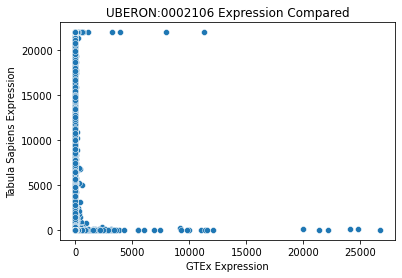

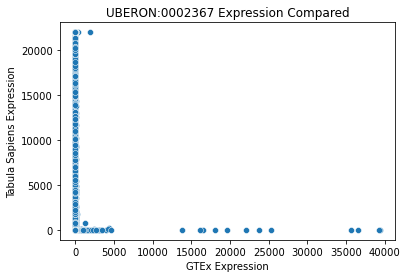

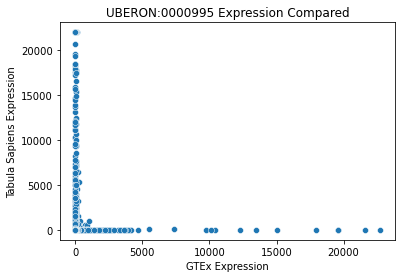

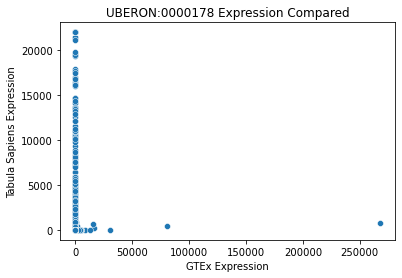

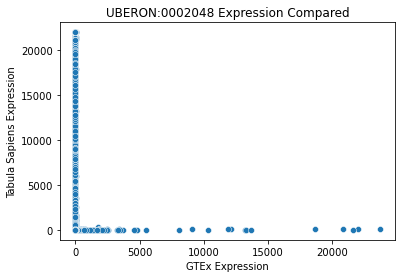

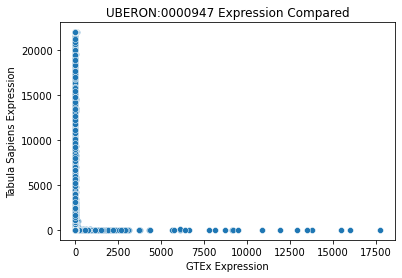

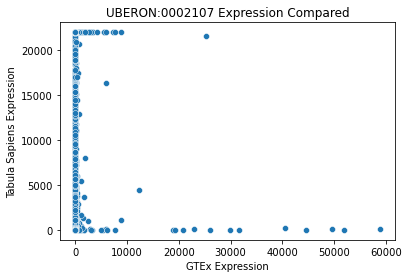

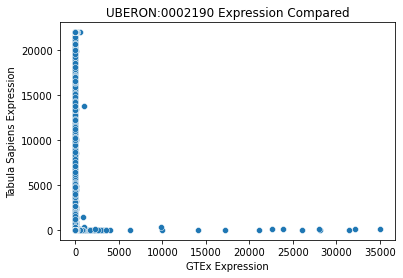

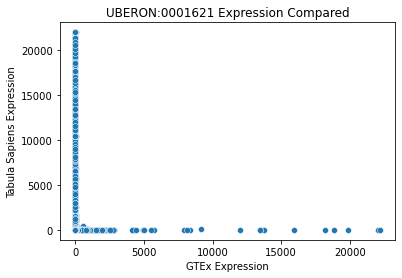

In [35]:
#plot GTEx expression against the expression in the highest proportion cell type of the tissue
for i in shared_uberon_ids:
    subset = uberon_subset(i, merged_shared_uberon_id_celltype_datasets.fillna(0))
    plt.title(f'{i} Expression Compared')
    plot_gtex_tabula(subset)

# ------------------------------------ Tabula Sapiens ---------------------------------------------------

# 4. Gene expression distributions across cell types

In [220]:
#read in data from saved pickle
tabula_sapiens = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

In [221]:
#drop genes that have NaN expression across all cell types
tabula_sapiens = tabula_sapiens.dropna(axis = 1, how = 'all')
tabula_sapiens

ENSG00000227232  ENSG00000238009  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000233750  ENSG00000268903  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000269981  ENSG00000241860  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000241599  ENSG00000279457  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

In [222]:
tabula_sapiens.to_pickle('dropped_gene_median_metric_tabula_counts.pkl', compression = 'gzip')

In [212]:
def gene_expression_dist(gene):
    gene_df = pd.DataFrame(tabula_sapiens[gene])
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), gene_df.plot.hist()

## 4.1 Housekeeping genes

### 4.1.1 Glyceraldehyde 3-phosphate dehydrogenase

(                                 ENSG00000111640
 tissue         cell_type                        
 UBERON:0002382 fast muscle cell       255.684875
 UBERON:0008612 fast muscle cell       183.204712
 UBERON:0002385 fast muscle cell       181.624695
 UBERON:0002382 slow muscle cell       143.423676
 UBERON:0002385 slow muscle cell       100.548531
 ...                                          ...
 UBERON:0008612 erythrocyte                   NaN
                mast cell                     NaN
                mature nk t cell              NaN
 UBERON:0010032 schwann cell                  NaN
 UBERON:0010033 schwann cell                  NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

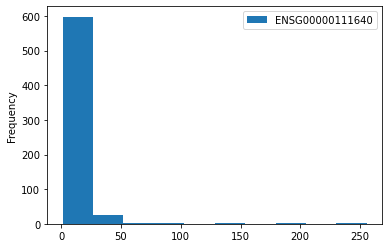

In [213]:
gene_expression_dist('ENSG00000111640')

### 4.1.2 Ubiquitin C

(                                           ENSG00000150991
 tissue         cell_type                                  
 UBERON:0002378 slow muscle cell                 161.947510
                fast muscle cell                  93.181671
 UBERON:0000970 corneal epithelial cell           71.685738
 UBERON:0002108 intestinal crypt stem cell        65.723389
 UBERON:0000964 corneal epithelial cell           57.167198
 ...                                                    ...
 UBERON:0008612 erythrocyte                             NaN
                mast cell                               NaN
                mature nk t cell                        NaN
 UBERON:0010032 schwann cell                            NaN
 UBERON:0010033 schwann cell                            NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

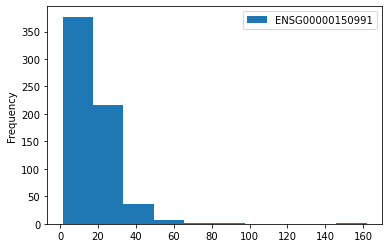

In [214]:
gene_expression_dist('ENSG00000150991')

### 4.1.3 RNA polymerase II A

(                                                              ENSG00000181222
 tissue         cell_type                                                     
 UBERON:0002190 neutrophil                                           17.217669
 UBERON:0000029 neutrophil                                           15.813733
 UBERON:0000059 intestinal crypt stem cell of large intestine        15.567108
 UBERON:0001911 endothelial cell of lymphatic vessel                 15.293393
 UBERON:0002106 neutrophil                                           15.176344
 ...                                                                       ...
 UBERON:0010032 schwann cell                                               NaN
                tongue muscle cell                                         NaN
 UBERON:0010033 endothelial cell of lymphatic vessel                       NaN
                schwann cell                                               NaN
                tongue muscle cell                  

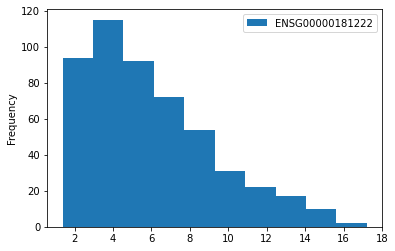

In [215]:
gene_expression_dist('ENSG00000181222')

### 4.1.4 Actin beta A

(                                 ENSG00000075624
 tissue         cell_type                        
 UBERON:0002106 platelet               131.805283
 UBERON:0000178 platelet               106.908562
 UBERON:0003126 neutrophil              85.560898
 UBERON:0002371 cd24 neutrophil         82.335190
 UBERON:0000016 mast cell               79.327095
 ...                                          ...
 UBERON:0008612 fast muscle cell              NaN
                mature nk t cell              NaN
                slow muscle cell              NaN
 UBERON:0010032 schwann cell                  NaN
 UBERON:0010033 schwann cell                  NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

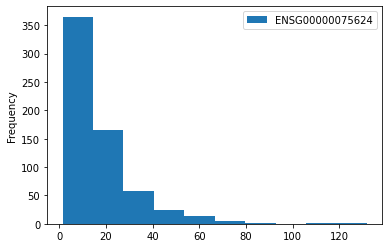

In [216]:
gene_expression_dist('ENSG00000075624')

## 4.2 Highly specifically expressed genes
### 4.2.1 Insulin (pancreatic beta cells)

(                                            ENSG00000254647
 tissue         cell_type                                   
 UBERON:0000016 pancreatic beta cell            22025.464844
                pancreatic pp cell              22025.464844
                t cell                          22025.464844
 UBERON:0000017 pancreatic beta cell            22025.464844
                pancreatic alpha cell           22025.464844
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

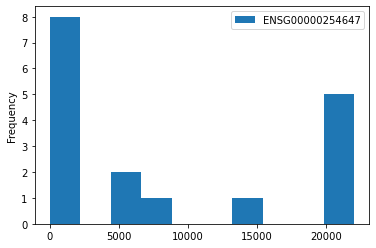

In [217]:
gene_expression_dist('ENSG00000254647')

### 4.2.2 Surfactant protein C (alveolar type II epithelial lung cells)

(                                            ENSG00000168484
 tissue         cell_type                                   
 UBERON:0002048 type ii pneumocyte               1609.377197
                lung ciliated cell               1559.597656
                respiratory goblet cell          1426.608643
                basal cell                       1196.632202
                club cell                        1107.909912
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

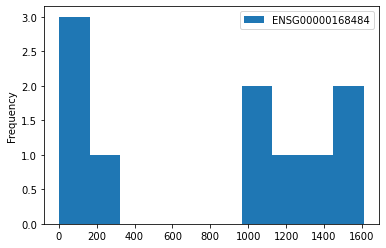

In [218]:
gene_expression_dist('ENSG00000168484')

### 4.2.3 Amylase 2B (pancreatic exocrine glandular cells)

(                                            ENSG00000243480
 tissue         cell_type                                   
 UBERON:0000016 pancreatic acinar cell          22025.464844
 UBERON:0000017 pancreatic acinar cell           5129.000977
                pancreatic ductal cell            166.294281
                t cell                            121.521805
 UBERON:0000016 endothelial cell                   42.099739
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

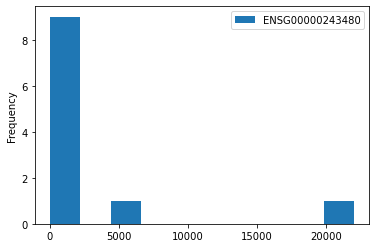

In [219]:
gene_expression_dist('ENSG00000243480')

# 5. Gene distribution across cell types in single tissue (lung)

In [223]:
#read in dropped gene tabula data
tabula_sapiens = pd.read_pickle('dropped_gene_median_metric_tabula_counts.pkl', compression = 'gzip')

In [224]:
lung = tabula_sapiens.loc['UBERON:0002048']
lung

,ENSG00000227232,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,ENSG00000241860,ENSG00000241599,ENSG00000279457,ENSG00000228463,ENSG00000237094,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,2.304915,NaN,NaN,NaN,NaN,NaN,NaN,2.912158,NaN,NaN,...,11.643223,NaN,6.253154,NaN,11.728609,9.309256,6.031812,43.097694,NaN,10.343433
alveolar fibroblast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.474730,NaN,NaN,NaN,8.630848,4.744880,NaN,41.891075,NaN,9.876362
b cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.461964,NaN,NaN,NaN,10.320301,4.983713,NaN,53.896442,NaN,NaN
basal cell,2.847742,NaN,NaN,NaN,NaN,NaN,NaN,2.368604,948.199219,777.370239,...,22.300692,33.876263,NaN,NaN,12.669003,3.254497,2.876836,59.612793,39.775726,6.342875
basophil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.899307,NaN,NaN,NaN,17.898926,4.656074,NaN,74.102928,NaN,NaN
bronchial smooth muscle cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.119442,NaN,NaN,NaN,10.194448,4.724723,NaN,47.871376,NaN,NaN
bronchial vessel endothelial cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.817963,9.327682,6.164498,NaN,7.743458,2.873157,15.236286,19.667601,NaN,7.463778
capillary aerocyte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.402452,NaN,NaN,NaN,6.749873,5.115723,NaN,19.603582,534.893127,NaN
capillary endothelial cell,10.658262,NaN,NaN,NaN,NaN,NaN,NaN,6.288942,NaN,NaN,...,10.099558,NaN,NaN,NaN,7.138210,5.695997,3.431229,21.899277,886.203186,12.172960


In [225]:
def gene_expression_dist(gene):
    gene_df = pd.DataFrame(lung[gene])
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), gene_df.plot.hist()

## 5.1 Housekeeping genes
### 5.1.1 TBP

(                                        ENSG00000112592
 cell_type                                              
 pericyte cell                                522.948303
 cd4-positive, alpha-beta t cell              452.832672
 capillary aerocyte                           374.766113
 cd8-positive, alpha-beta t cell              252.466003
 capillary endothelial cell                   245.198700
 intermediate monocyte                        116.514458
 alveolar fibroblast                          104.533157
 classical monocyte                           103.258011
 basophil                                      88.130798
 non-classical monocyte                        72.668175
 lung microvascular endothelial cell           58.570095
 vein endothelial cell                         52.372791
 club cell                                     43.200878
 endothelial cell of artery                    31.893467
 dendritic cell                                25.159729
 adventitial cell              

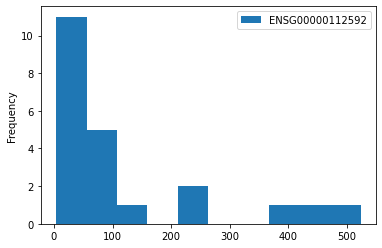

In [226]:
gene_expression_dist('ENSG00000112592')

### 5.1.2 GADPH

(                                        ENSG00000111640
 cell_type                                              
 bronchial vessel endothelial cell             19.245228
 classical monocyte                            17.675255
 smooth muscle cell                            15.927636
 pulmonary ionocyte                            14.246191
 lung microvascular endothelial cell           13.573997
 dendritic cell                                12.763678
 capillary aerocyte                            12.491606
 intermediate monocyte                         11.164561
 adventitial cell                              10.503680
 basal cell                                    10.035592
 bronchial smooth muscle cell                   9.807484
 vein endothelial cell                          9.326166
 cd8-positive, alpha-beta t cell                9.136560
 mesothelial cell                               8.735196
 cd4-positive alpha-beta t cell                 8.669743
 endothelial cell of artery    

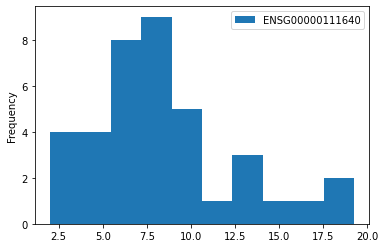

In [227]:
gene_expression_dist('ENSG00000111640')

### 5.1.3 UBC

(                                        ENSG00000150991
 cell_type                                              
 adventitial cell                              44.837044
 fibroblast                                    31.610472
 type i pneumocyte                             31.123575
 alveolar fibroblast                           27.277084
 capillary aerocyte                            25.045265
 endothelial cell of artery                    24.413479
 bronchial smooth muscle cell                  22.788437
 vascular associated smooth muscle cell        20.475605
 basal cell                                    19.630524
 capillary endothelial cell                    19.463711
 pulmonary ionocyte                            19.415474
 vein endothelial cell                         18.904091
 mesothelial cell                              18.516920
 type ii pneumocyte                            18.387094
 pericyte cell                                 18.264965
 myofibroblast cell            

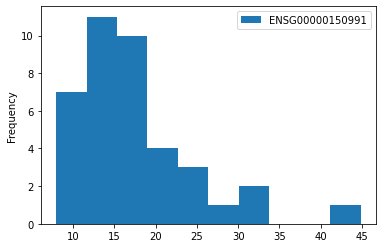

In [228]:
gene_expression_dist('ENSG00000150991')

## 5.2 Highly specific genes
### 5.2.1 INS

(                                        ENSG00000254647
 cell_type                                              
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basal cell                                          NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte                                  NaN
 capillary endothelial cell                          NaN
 cd4-positive alpha-beta t cell                      NaN
 cd4-positive, alpha-beta t cell                     NaN
 cd8-positive alpha-beta t cell                      NaN
 cd8-positive, alpha-beta t cell                     NaN
 classical monocyte                                  NaN
 club cell                                           NaN
 dendritic cell                

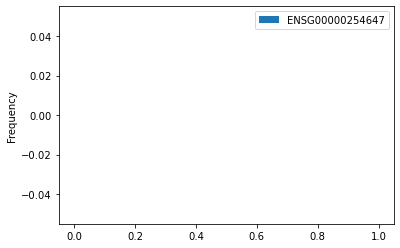

In [229]:
gene_expression_dist('ENSG00000254647') #i.e. no expression of insulin in these lung cells

### 5.2.2 SFTPC

(                                        ENSG00000168484
 cell_type                                              
 type ii pneumocyte                          1609.377197
 lung ciliated cell                          1559.597656
 respiratory goblet cell                     1426.608643
 basal cell                                  1196.632202
 club cell                                   1107.909912
 type i pneumocyte                            975.768188
 macrophage                                   292.158844
 neutrophil                                     4.286518
 plasma cell                                    3.663638
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte            

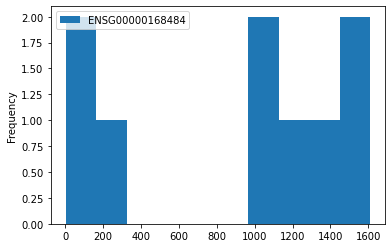

In [230]:
gene_expression_dist('ENSG00000168484')

### 5.2.3 AMY2B

(                                        ENSG00000243480
 cell_type                                              
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basal cell                                          NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte                                  NaN
 capillary endothelial cell                          NaN
 cd4-positive alpha-beta t cell                      NaN
 cd4-positive, alpha-beta t cell                     NaN
 cd8-positive alpha-beta t cell                      NaN
 cd8-positive, alpha-beta t cell                     NaN
 classical monocyte                                  NaN
 club cell                                           NaN
 dendritic cell                

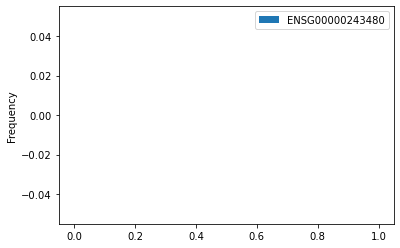

In [231]:
gene_expression_dist('ENSG00000243480') #i.e. no expression of AMY2B in these cells

# 6. Distribution of genes across all cells in a single tissue (lung)

In [2]:
#read in whole Tabula Sapiens dataset
all_cells = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

In [3]:
#filter out lung cells
lung = all_cells[all_cells.obs.tissue_ontology_term_id == 'UBERON:0002048']

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [4]:
#convert sparse matrix to dense matrix and exponentiate expression values
lung_counts = pd.DataFrame.sparse.from_spmatrix(lung.X)
lung_counts = np.expm1(lung_counts)

In [5]:
#add gene names to the columns
gene_names = lung.var.index.values
lung_counts = lung_counts.set_axis(gene_names, axis = 1)

#add cell type
cell_type = lung.obs['cell_ontology_class'].values
lung_counts.insert(0, 'cell_type', cell_type)

lung_counts = lung_counts.drop(lung_counts.columns[(lung_counts == 0).all()], axis = 1)

In [6]:
lung_counts

,cell_type,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000240361,ENSG00000238009,ENSG00000239945,ENSG00000233750,ENSG00000268903,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,29.522684,2.162206,0.000000,0.0,4.916226,1.774017,0.000000,38.670734,0.000000,0.501866
1,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,54.292229,0.000000,7.440341,0.0,10.121305,1.045985,1.703557,77.216110,16.125153,16.106915
2,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,57.446617,0.000000,0.000000,0.0,6.876759,0.000000,0.000000,91.006187,742.667969,0.000000
3,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,35.597107,0.000000,4.850770,0.0,10.596470,2.675121,2.093883,55.183472,5.199052,3.902307
4,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,42.046162,0.000000,0.000000,0.0,5.038349,1.063540,0.000000,50.367680,0.000000,0.834576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,macrophage,0.0,0.192152,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,9.547097,0.000000,0.000000,0.0,1.227417,7.775701,2.027940,27.854317,0.000000,9.888508
35678,plasma cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,3.653382,0.000000,0.000000,0.0,4.010193,3.241796,0.131419,11.836517,0.000000,4.659379
35679,lung microvascular endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,34.462471,0.000000,0.000000,0.0,64.982445,3121.358154,977.833069,19.161039,0.000000,0.000000
35680,neutrophil,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,1.666218,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
def gene_expression_dist(gene):
    gene_df = pd.DataFrame(lung_counts[gene])
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), gene_df.plot.hist(bins = 200)

## 6.1 Housekeeping genes
### 6.1.1 TBP

(       ENSG00000112592
 17538     22025.464844
 17543     22025.464844
 17391     22025.464844
 7081      10871.542969
 17000      9724.833984
 ...                ...
 17301         0.018035
 17260         0.015536
 34785         0.011285
 35475         0.010427
 34875         0.009874
 
 [4135 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

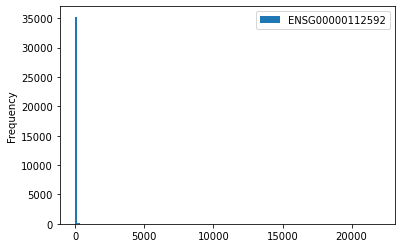

In [40]:
gene_expression_dist('ENSG00000112592')

### 6.1.2 GADPH

(       ENSG00000111640
 17257       139.732819
 17077       104.785324
 17161        93.782806
 34838        68.739792
 17059        64.421562
 ...                ...
 17226         0.019493
 17285         0.014508
 17013         0.011145
 17052         0.009790
 16980         0.004210
 
 [33791 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

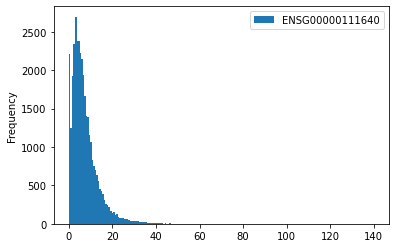

In [41]:
gene_expression_dist('ENSG00000111640')

### 6.1.3 UBC

(       ENSG00000150991
 9831        451.778137
 17039       303.227356
 7359        286.216095
 9965        276.679016
 12790       268.299133
 ...                ...
 16990         0.096152
 17061         0.039150
 35599         0.037328
 17063         0.026555
 17443         0.025698
 
 [35134 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

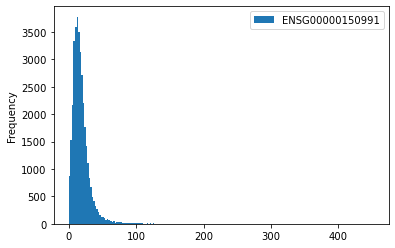

In [42]:
gene_expression_dist('ENSG00000150991')

## 6.2 Highly specific genes
### 6.2.1 INS

(       ENSG00000254647
 8754      22025.464844
 10425     20341.980469
 10052      2126.052002
 11991        41.587708
 9957         27.267170
 11633        26.226860
 8566         22.681904
 13295        18.712683
 16348        18.352549
 9543          7.217002,
 <AxesSubplot:ylabel='Frequency'>)

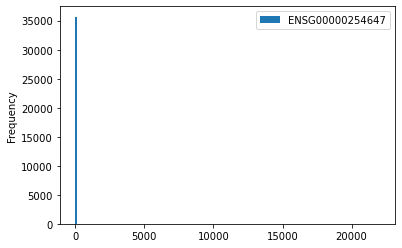

In [43]:
gene_expression_dist('ENSG00000254647')

### 6.2.2 SFTPC

(       ENSG00000168484
 35095      9214.166016
 16961      9130.375000
 16901      8732.451172
 25605      8345.250977
 35087      7580.894531
 ...                ...
 10970         0.421243
 7104          0.386240
 4406          0.319181
 9230          0.210344
 11654         0.208874
 
 [9488 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

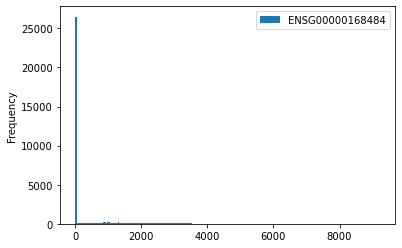

In [44]:
gene_expression_dist('ENSG00000168484')

### 6.2.3 AMY2B

(       ENSG00000243480
 13189        13.366562
 17344         0.146436,
 <AxesSubplot:ylabel='Frequency'>)

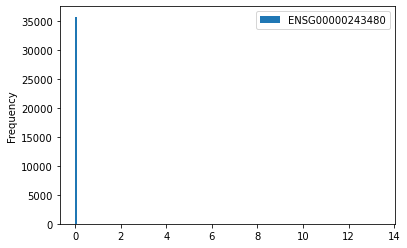

In [45]:
gene_expression_dist('ENSG00000243480')

# 7. Comparison of lung expressions (Tabula Sapien cell types vs GTEx)

In [2]:
#read in whole median expression counts Tabula Sapiens dataset
all_cells = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

## 7.1 Unique cell types in the lung

In [3]:
#filter out lung cells from grouped expressions from all cells
lung = all_cells.loc['UBERON:0002048']
lung

,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,NaN,2.304915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.643223,NaN,6.253154,NaN,11.728609,9.309256,6.031812,43.097694,NaN,10.343433
alveolar fibroblast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.474730,NaN,NaN,NaN,8.630848,4.744880,NaN,41.891075,NaN,9.876362
b cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.461964,NaN,NaN,NaN,10.320301,4.983713,NaN,53.896442,NaN,NaN
basal cell,NaN,2.847742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.300692,33.876263,NaN,NaN,12.669003,3.254497,2.876836,59.612793,39.775726,6.342875
basophil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.899307,NaN,NaN,NaN,17.898926,4.656074,NaN,74.102928,NaN,NaN
bronchial smooth muscle cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.119442,NaN,NaN,NaN,10.194448,4.724723,NaN,47.871376,NaN,NaN
bronchial vessel endothelial cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.817963,9.327682,6.164498,NaN,7.743458,2.873157,15.236286,19.667601,NaN,7.463778
capillary aerocyte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.402452,NaN,NaN,NaN,6.749873,5.115723,NaN,19.603582,534.893127,NaN
capillary endothelial cell,NaN,10.658262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.099558,NaN,NaN,NaN,7.138210,5.695997,3.431229,21.899277,886.203186,12.172960


This shows there are 40 unique cell types in the liver whose expression can be plotted against the bulk expression. I next want to understand how many cells were captured for each cell type; this was done using a previous version accounting for all cells.

In [37]:
#this can no longer be run but was obtained by creating a dataframe from the total cells expression counts and filtering for lung
lung_counts.groupby('cell_type').ENSG00000223972.count().sort_values(ascending = False)

/tmp/ipykernel_1870/1985686269.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lung_counts.groupby('cell_type').ENSG00000223972.count().sort_values(ascending = False)


cell_type
macrophage                                12160
type ii pneumocyte                         9146
basal cell                                 2188
classical monocyte                         1487
club cell                                  1038
non-classical monocyte                     1005
capillary endothelial cell                  965
respiratory goblet cell                     754
basophil                                    686
lung ciliated cell                          602
capillary aerocyte                          569
cd8-positive, alpha-beta t cell             552
cd4-positive, alpha-beta t cell             543
vein endothelial cell                       508
lung microvascular endothelial cell         485
adventitial cell                            373
alveolar fibroblast                         324
dendritic cell                              316
intermediate monocyte                       252
pericyte cell                               213
type i pneumocyte             

# 7.2 Plot cell expression vs GTEx expression for each cell type in lung

### 7.2.1 Load GTEx data

In [4]:
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')

### 7.2.2 Filter for lung GTEx data

In [41]:
lung_GTEx = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0002048'])
lung_GTEx = lung_GTEx.rename(columns = {'UBERON:0002048': 'GTEx_lung'})
lung_GTEx

,GTEx_lung
ENSG00000223972,0.000000
ENSG00000227232,4.508410
ENSG00000243485,0.000000
ENSG00000268020,0.000000
ENSG00000240361,0.039284
...,...
ENSG00000198695,5485.010000
ENSG00000210194,20.290200
ENSG00000198727,11896.000000
ENSG00000210195,0.723844


### 7.2.3 Define function to merge GTEx lung expression data with Tabula Sapiens lung cell type expression data

In [42]:
def plot_GTEx_lung_cell_type(cell_type):
    
    #filter tabula lung expression df for the cell type of interest
    cell_type_df = pd.DataFrame(lung.loc[cell_type])
    
    expression_df = pd.concat([lung_GTEx, cell_type_df], axis = 1).fillna(0)
    
    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx_lung', y = cell_type, data = expression_df)
    plt.xlabel('GTEx Expression')
    plt.ylabel(f'Tabula Sapiens {cell_type} Expression')
    
    return plt.show()

### 7.2.4 Plot scatterplots for Tabula lung cell type expression vs GTEx lung (median expression counts)

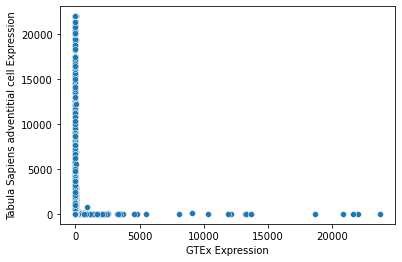

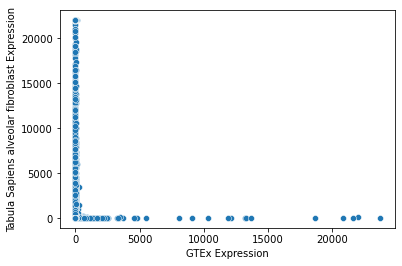

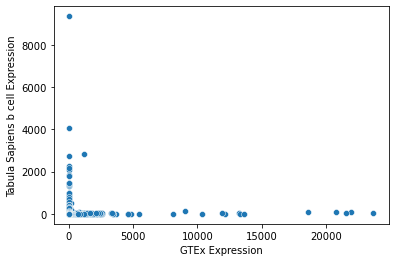

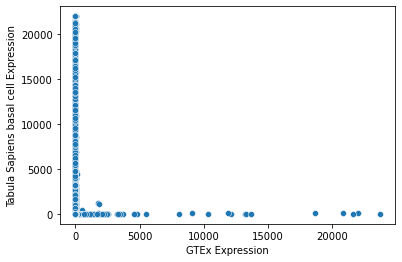

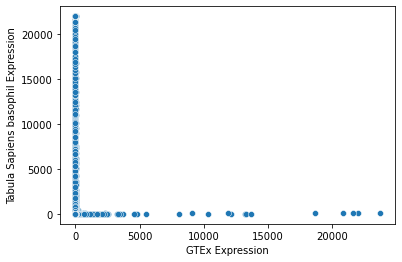

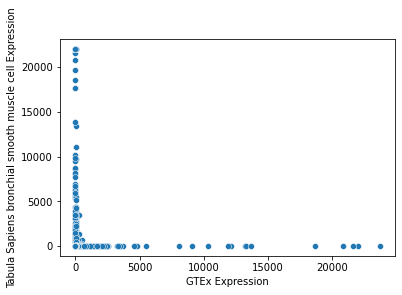

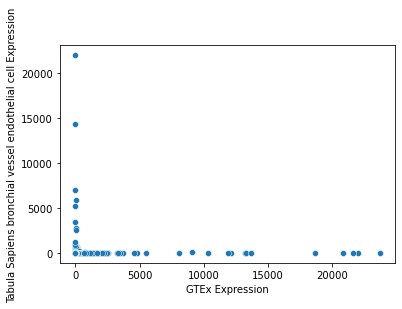

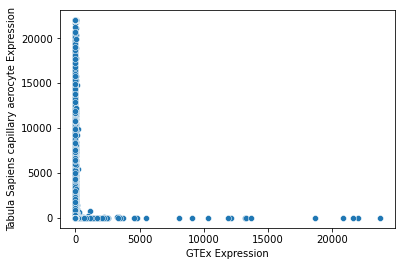

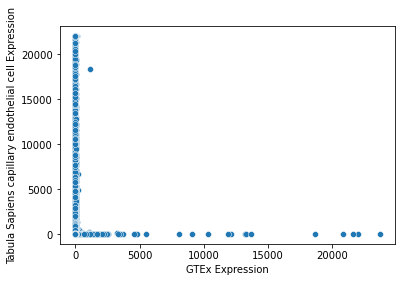

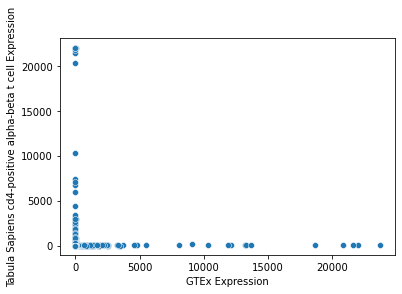

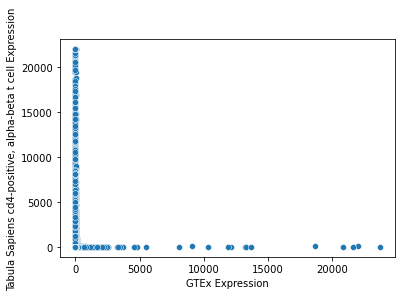

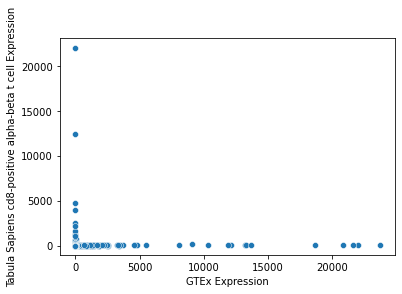

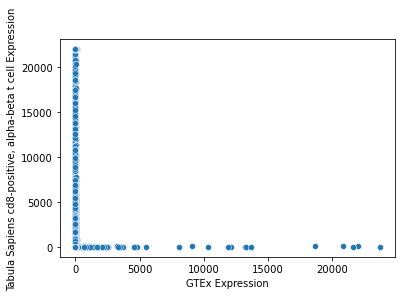

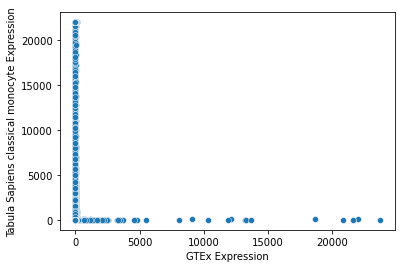

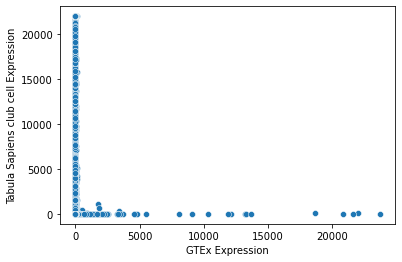

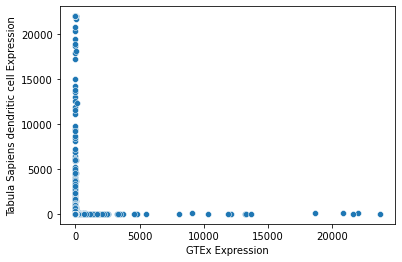

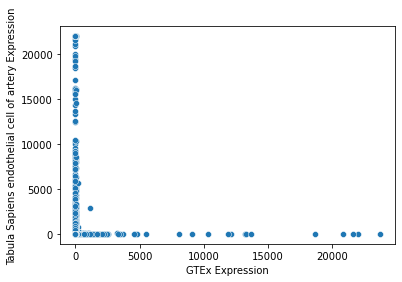

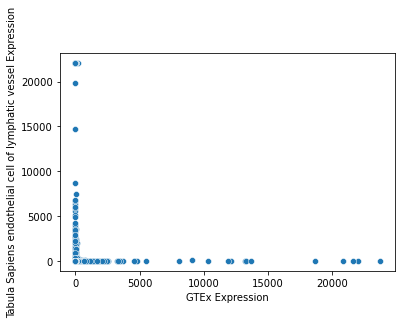

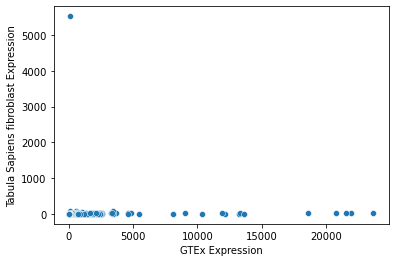

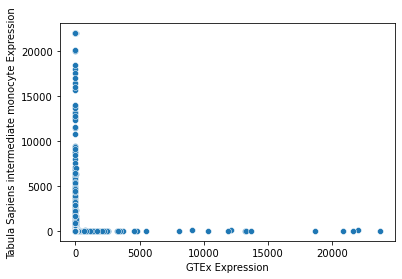

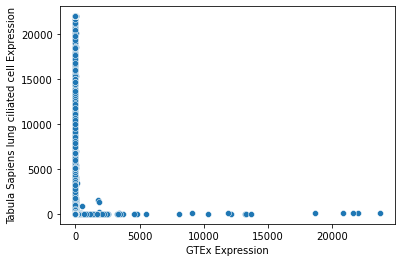

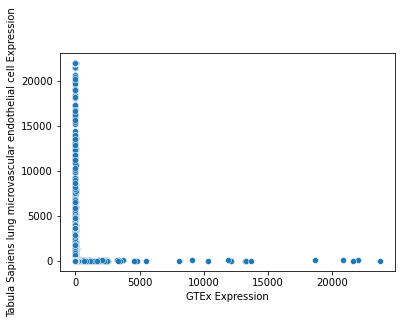

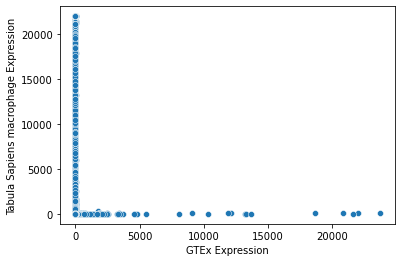

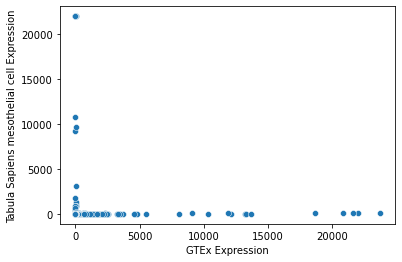

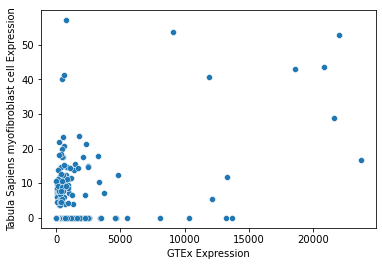

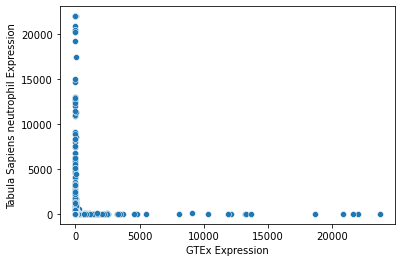

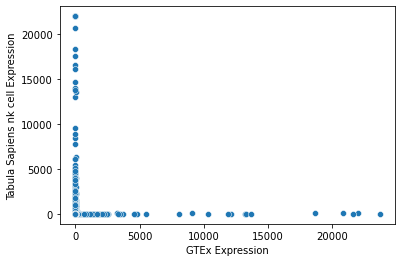

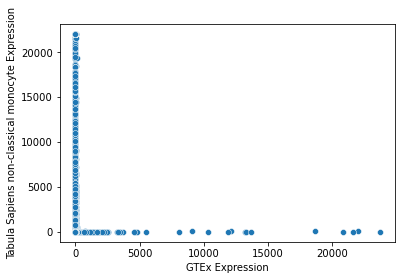

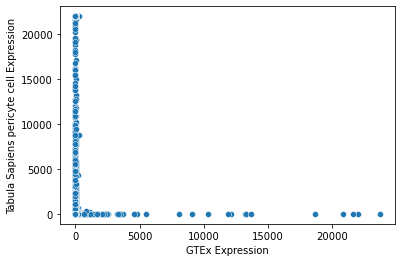

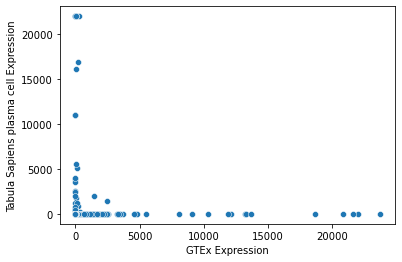

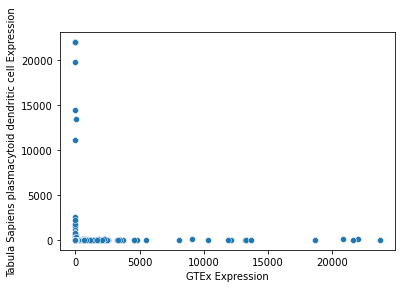

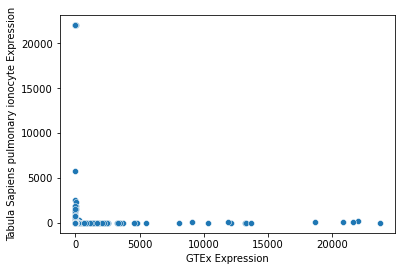

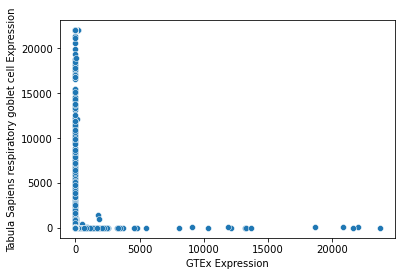

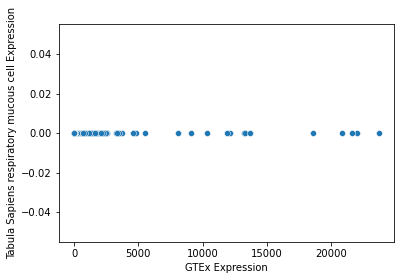

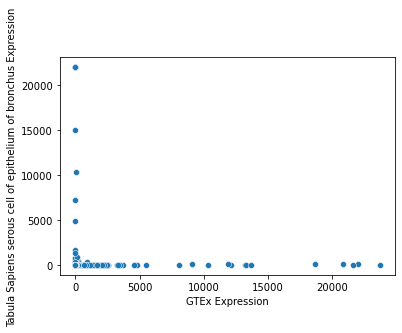

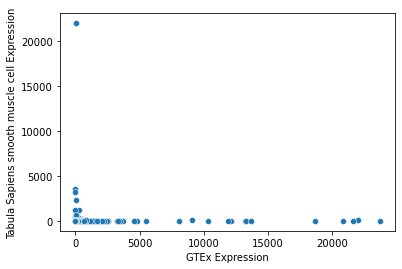

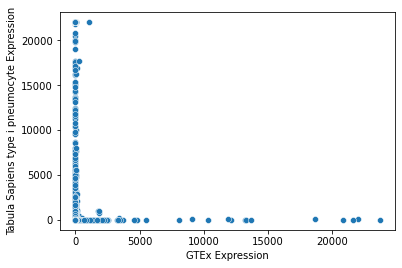

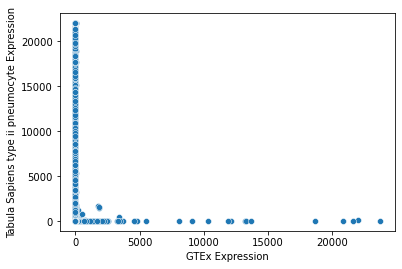

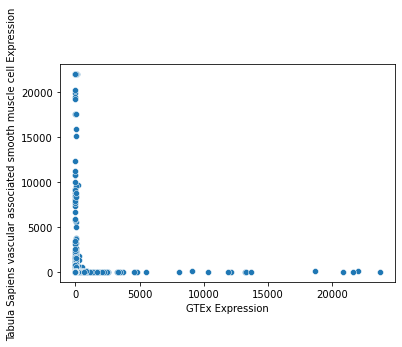

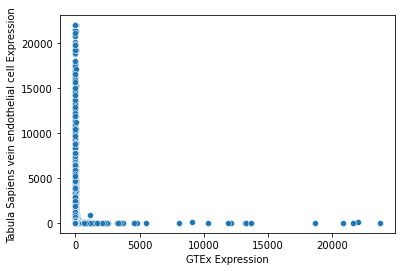

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in lung.index:
    plot_GTEx_lung_cell_type(f'{i}')

For most of the cell types the median expression across the two datasets are an order of magnitude apart with GTEx TPM expression ranging in the thousands and tabula sapiens often ranging in the hundreds however there are some genes which show a much higher expression in Tabula Sapiens than others. Nevertheless, there doesn't appear to be much correlation between the GTEx and Tabula Sapiens expression values.

# 8. Comparing gene expression in pancreas across GTEx and Tabula Sapiens
## 8.1 Pre-process pancreas data
### 8.1.1 Tabula Sapiens pancreas

In [2]:
#load adata for Tabula Sapiens
all_cells_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

#processing exocrine and endocrine pancreas count data
exo_pancreas = pd.DataFrame.sparse.from_spmatrix(exo_pancreas_adata.X)
exo_pancreas = np.expm1(exo_pancreas)
exo_pancreas = exo_pancreas.sparse.to_dense()
exo_pancreas = exo_pancreas.set_axis(exo_pancreas_adata.var.index.values, axis = 1)
exo_pancreas.insert(0, 'cell_type', exo_pancreas_adata.obs['cell_ontology_class'].values)


endo_pancreas = pd.DataFrame.sparse.from_spmatrix(endo_pancreas_adata.X)
endo_pancreas = np.expm1(endo_pancreas)
endo_pancreas = endo_pancreas.sparse.to_dense()
endo_pancreas = endo_pancreas.set_axis(endo_pancreas_adata.var.index.values, axis = 1)
endo_pancreas.insert(0, 'cell_type', endo_pancreas_adata.obs['cell_ontology_class'].values)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [3]:
#merge the endocrine and exocrine pancreas data together
pancreas = pd.concat([exo_pancreas, endo_pancreas], ignore_index = True)

In [ ]:
pancreas.to_pickle('total_pancreas_counts.pkl', compression = 'gzip')

**READ IN PANCREAS COUNTS DATA**

In [27]:
pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

**NEED TO SET THE INDEX FIRST BEFORE USING THE FUNCTION OTHERWISE IT TREATS THE CELL_TYPE AS A COLUMN**

In [28]:
pancreas.set_index('cell_type', inplace = True)

In [31]:
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

#define minimum expression threshold for counts
MIN_EXPRESSION_THRESHOLD = 1
    
#define minimum number of observations to calculate median metric
MIN_OBSERVED_THRESHOLD = 10

def average_metric(df):
    
    # Set all values < expression threshold, including zeroes, to nan.
    df[df < MIN_EXPRESSION_THRESHOLD] = np.nan
    
    # Compute median expression values for all genes.
    median = df.median()
    
    # Filter out genes where we have too few observations.
    observation_mask = (~ df.isna()).sum() < MIN_OBSERVED_THRESHOLD
    median[observation_mask] = np.nan
    
    return median

pancreas_median = pancreas.groupby('cell_type', observed = True).parallel_apply(average_metric)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [33]:
pancreas_median.to_pickle('pancreas_median_counts.pkl', compression = 'gzip')

In [43]:
#read in whole pancreas median data for each cell type
pancreas = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')

### 8.1.2 GTEx pancreas

In [36]:
#read in GTEx data that has been adjusted for gene ensemblids and had duplicate tissues and cell ontologies removed
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')

In [40]:
#new GTEx v8 mappings are more region specific so pancreas is now UBERON:0001150
GTEx_pancreas = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0001150'])
GTEx_pancreas = GTEx_pancreas.rename(columns = {'UBERON:0001150': 'GTEx_pancreas'})

## 8.2 Plot gene expression across each pancreatic cell type to GTEx expression

In [44]:
def plot_GTEx_pancreas_cell_type(cell_type):
    
    #filter tabula pancreas expression df for the cell type of interest
    cell_type_df = pd.DataFrame(pancreas.loc[cell_type])
    
    expression_df = pd.concat([GTEx_pancreas, cell_type_df], axis = 1).fillna(0)
    
    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx_pancreas', y = cell_type, data = expression_df)
    plt.xlabel('GTEx Expression')
    plt.ylabel(f'Tabula Sapiens {cell_type} Expression')
    plt.title(f'Comparing gene expression between GTEx and Tabula Sapiens {cell_type}')
    
    return plt.show()

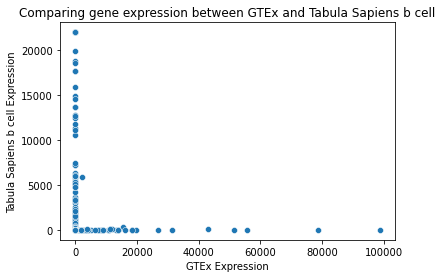

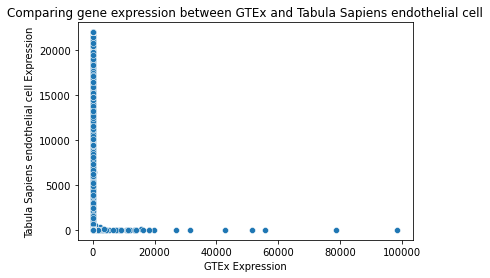

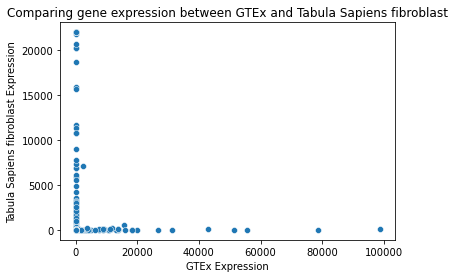

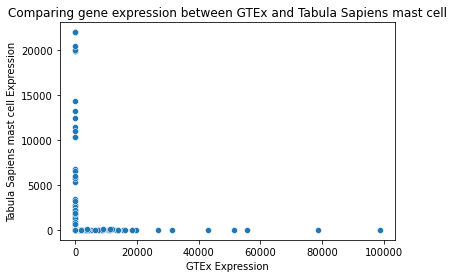

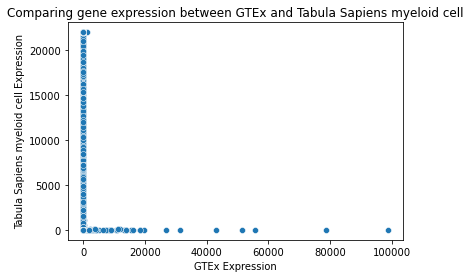

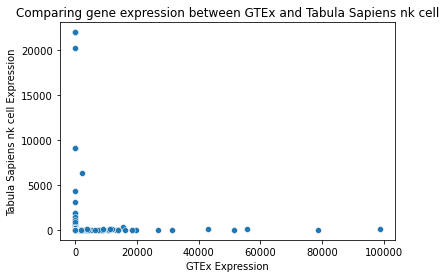

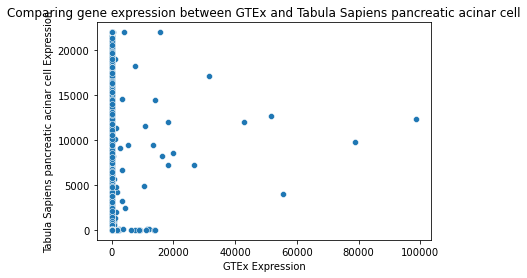

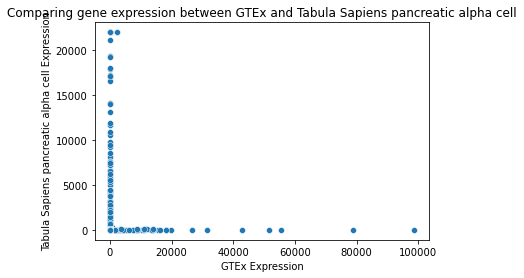

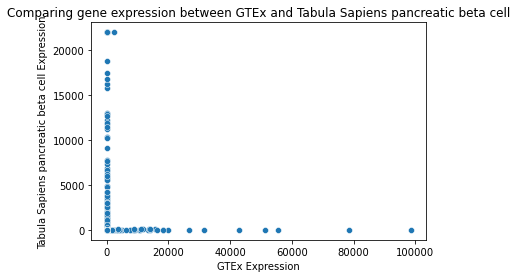

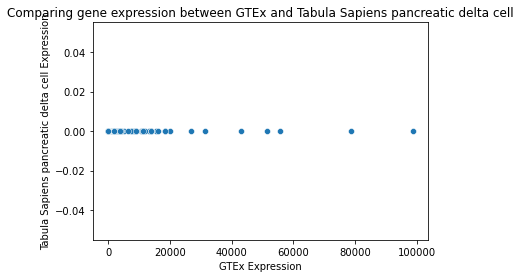

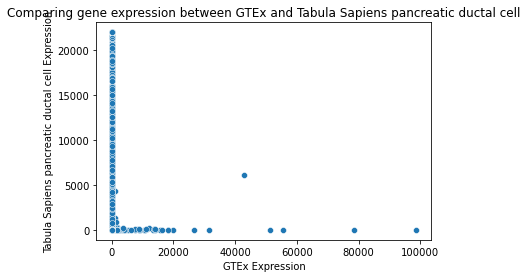

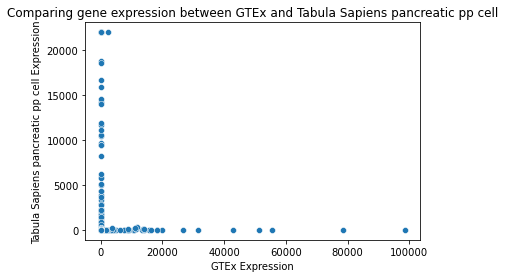

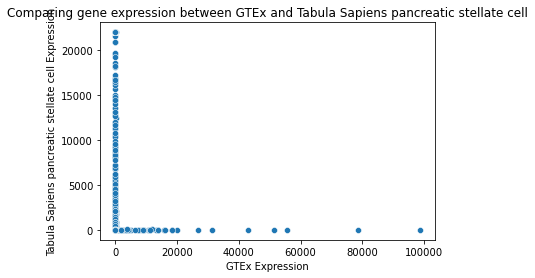

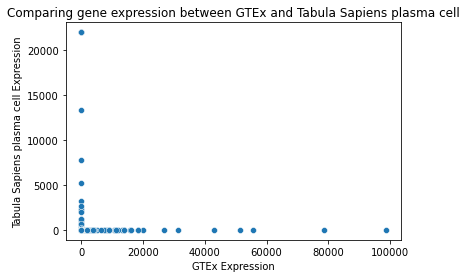

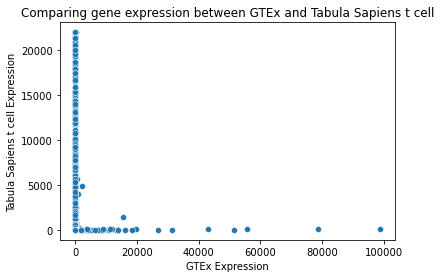

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in pancreas.index:
    plot_GTEx_pancreas_cell_type(f'{i}')

This shows that the median expressions across multiple genes in Tabula Sapiens and GTEx are often not on the same magnitude scale of expression.

## 8.3 Plot insulin expression across individual Tabula cells vs GTEx median

In [47]:
total_cell_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

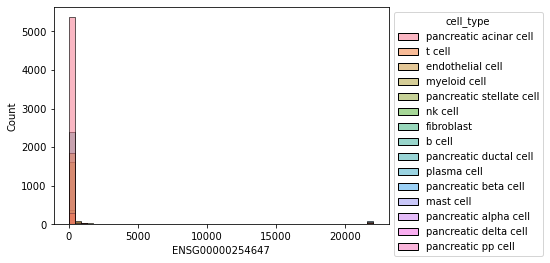

In [15]:
ax = sns.histplot(data = total_cell_pancreas, x = 'ENSG00000254647', bins = 50, hue ='cell_type')
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

**Remove zero counts to view expression values better**

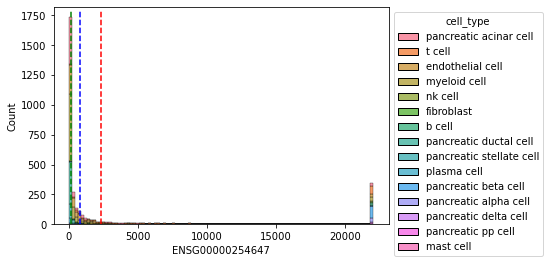

In [48]:
#plotting histogram of total cell NON-ZERO expression counts for insulin gene in pancreas
ax = sns.histplot(data = total_cell_pancreas[total_cell_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', bins = 100, 
                  hue ='cell_type', multiple = 'stack')

#move legend outside of plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

#draw line where GTEx median insulin expression lies
ax.axvline(x = GTEx_pancreas.loc['ENSG00000254647'].values.tolist(), ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')

#mean of total pancreas cell counts for insulin (including zero-expression)
ax.axvline(x = total_cell_pancreas['ENSG00000254647'].mean(), ymin = 0, ymax = 0.98, color = 'blue', linestyle = 'dashed')

#median of total pancreas cell counts for insulin (EXcluding zero-expression)
ax.axvline(x = total_cell_pancreas[total_cell_pancreas['ENSG00000254647'] > 0]['ENSG00000254647'].median(), 
           ymin = 0, ymax = 0.98, color = 'green', linestyle = 'dashed')

Could taking the median of the non-zero expression of cell types be a better metric and if all zero then take the zero expression???????

# 9. Virtual lung (single-cell weighted median expression)
## 9.1 Read in data

In [63]:
#read in whole median expression counts Tabula Sapiens dataset
all_cells = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')

#filter out lung
lung = all_cells.loc['UBERON:0002048']

In [64]:
#read in GTEx expressions
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')

#filter out lung cells and rename column
lung_GTEx = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0002048'])
lung_GTEx = lung_GTEx.rename(columns = {'UBERON:0002048': 'GTEx_lung'})

## 9.2 Identify shared genes between Tabula Sapiens lung and GTEx lung data

In [65]:
print(f'Tabula lung has {len(lung.columns)} genes and GTEx lung has {len(lung_GTEx.index)} genes')

Tabula lung has 24166 genes and GTEx lung has 44219 genes


In [66]:
shared_genes = set(lung_GTEx.index) & set(lung.columns)
print(f' The number of shared genes between Tabula lung and GTEx lung is {len(shared_genes)}')

 The number of shared genes between Tabula lung and GTEx lung is 22956


## 9.3 Filter datasets for these genes

In [67]:
lung = lung[lung.columns.intersection(shared_genes)]
lung_GTEx = lung_GTEx.filter(items = shared_genes, axis = 0)

## 9.4 Calculate weighted median expression of genes for each cell type
### 9.4.1 Identify proportions of each cell type

In [58]:
lung_counts = pd.read_pickle('lung_counts.pkl', compression = 'gzip')

In [59]:
print(f'There are {len(lung_counts)} total lung cells')

There are 35682 total lung cells


In [68]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

lung_cell_type = pd.DataFrame(lung_counts.groupby('cell_type').ENSG00000223972.count())
lung_cell_type = lung_cell_type.rename(columns = {'ENSG00000223972': 'count'})

In [69]:
lung_cell_type['proportion'] = lung_cell_type['count'] / len(lung_counts)

### 9.4.2 Multiply each cell type row by the proportion

In [70]:
#list of cell type proportions
proportion_list = lung_cell_type['proportion'].to_list()

#extract gene columns for multiplication
gene_columns = lung.columns.difference(['cell_type'])

#multiply each column in the row by the corresponding cell type proportion
lung[gene_columns] = lung[gene_columns].mul(proportion_list, axis = 0)

lung

,ENSG00000227232,ENSG00000268903,ENSG00000241860,ENSG00000279457,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.012370,0.004192,0.001766,0.006702,...,0.121580,0.0,0.000000,0.0,0.121627,0.073641,0.000000,0.450520,0.000000,0.009589
alveolar fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.182421,0.0,0.000000,0.0,0.068253,0.000000,0.000000,0.375447,0.000000,0.000000
b cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.110846,0.0,0.000000,0.0,0.024334,0.000000,0.000000,0.130977,0.000000,0.000000
basal cell,0.0,0.0,0.0,0.0,0.0,0.0,0.291158,0.000000,0.000000,0.000000,...,1.366692,0.0,0.000000,0.0,0.767201,0.000000,0.000000,3.655423,0.000000,0.000000
basophil,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,1.457420,0.0,0.000000,0.0,0.342088,0.000000,0.000000,1.419554,0.000000,0.000000
bronchial smooth muscle cell,0.0,0.0,0.0,0.0,0.0,0.0,0.002150,0.000000,0.000000,0.000000,...,0.054752,0.0,0.000000,0.0,0.022821,0.000000,0.000000,0.108671,0.000000,0.000000
bronchial vessel endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.023470,0.0,0.002843,0.0,0.009054,0.000000,0.005320,0.025906,0.000000,0.003688
capillary aerocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.020808,0.000000,0.000000,0.000000,...,0.146172,0.0,0.000000,0.0,0.096670,0.000000,0.000000,0.311730,0.000000,0.000000
capillary endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.032101,0.000000,0.000000,0.000000,...,0.269720,0.0,0.000000,0.0,0.172803,0.000000,0.000000,0.586125,0.000000,0.000000


In [30]:
lung.to_pickle('weighted_median_cell_type_lung.pkl', compression = 'gzip')

## 9.5 Calculate sum of weighted expression for each gene across all cell types

In [ ]:
lung = pd.read_pickle('weighted_median_cell_type_lung.pkl', compression = 'gzip')

In [69]:
sum_weighted_gene_expression = pd.DataFrame(lung.columns)

sum_expression = []
for i in lung.columns:
    sum_expression.append(lung[i].sum())
    
sum_weighted_gene_expression['sum_expression'] = sum_expression
sum_weighted_gene_expression = sum_weighted_gene_expression.rename(columns = {0: 'geneProductId'})
sum_weighted_gene_expression = sum_weighted_gene_expression.set_index('geneProductId')

## 9.6 Compare Tabula sum expression to GTEx

In [70]:
expression_df = pd.concat([sum_weighted_gene_expression, lung_GTEx], axis = 1)
expression_df

,sum_expression,GTEx_lung
geneProductId,,
ENSG00000227232,0.000000,3.0
ENSG00000268903,0.000000,27.0
ENSG00000241860,0.000000,3.0
ENSG00000279457,0.000000,6.0
ENSG00000228463,0.000000,1.0
...,...,...
ENSG00000198695,0.207572,8809.0
ENSG00000210194,0.005711,394.0
ENSG00000198727,48.591060,15558.0


## 9.7 Plot Tabula data vs GTEx data

In [71]:
def tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    plt.show()
    
def zoomed_tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 50)
    plt.show()

<Figure size 432x288 with 0 Axes>

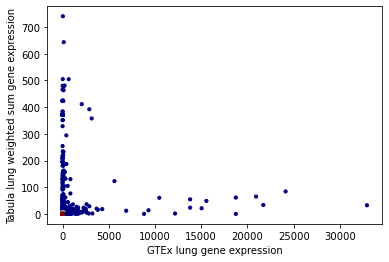

In [91]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

<Figure size 432x288 with 0 Axes>

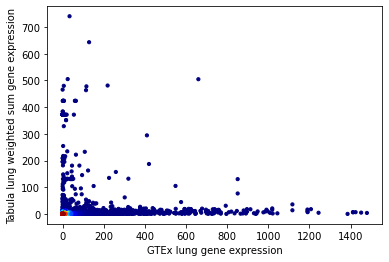

<Figure size 432x288 with 0 Axes>

In [84]:
tabula_vs_GTEx_expression(expression_df[expression_df.GTEx_lung < 1500].GTEx_lung, 
                          expression_df[expression_df.GTEx_lung < 1500].sum_expression)

plt.savefig('tabula_vs_GTEx_lung_expression.png')

<Figure size 432x288 with 0 Axes>

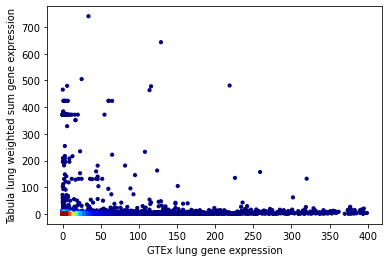

In [82]:
tabula_vs_GTEx_expression(expression_df[expression_df.GTEx_lung < 400].GTEx_lung, 
                          expression_df[expression_df.GTEx_lung < 400].sum_expression)

<Figure size 432x288 with 0 Axes>

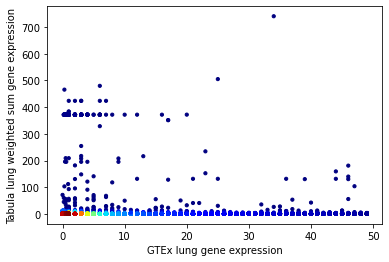

In [83]:
tabula_vs_GTEx_expression(expression_df[expression_df.GTEx_lung < 50].GTEx_lung, 
                          expression_df[expression_df.GTEx_lung < 50].sum_expression)

<Figure size 432x288 with 0 Axes>

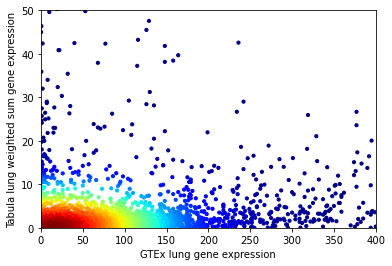

In [92]:
#zoom in on GTEx axis between 0-400 counts and zoom in on Tabula axis between 0-50
zoomed_tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

## 9.8 Genes with huge discrepancies between Tabula and GTEx

In [87]:
expression_df['difference'] = expression_df['sum_expression'] - expression_df['GTEx_lung']
expression_df.sort_values(['difference'], ascending = False)

,sum_expression,GTEx_lung,difference
geneProductId,,,
ENSG00000108576,740.203872,34.0,706.203872
ENSG00000164265,642.977633,129.0,513.977633
ENSG00000043591,504.851500,25.0,479.851500
ENSG00000125999,479.619589,6.0,473.619589
ENSG00000197446,465.422356,0.3,465.122356
...,...,...,...
ENSG00000228253,0.045188,18739.0,-18738.954812
ENSG00000198804,64.978049,20929.0,-20864.021951
ENSG00000198899,33.419304,21716.0,-21682.580696


ENSG00000228253, ENSG00000198804, ENSG00000198899, ENSG00000198712 and ENSG00000198886 are mitochondrially encoded genes suggesting that some mitochondrial contamination has remained after filtering: it has a medium expression in Tabula but is very high in GTEx suggesting that GTEx did not have a stringent enough mitochondrial filtering protocol. These mitochondrial genes however appear to make up a proportion of the genes that have a lower Tabula expression and a higher GTEx expression which correspond to the outliers on the GTEx axis. None of the top 10 genes with differences (positive or negative) are pseudogenes however. 

**For insight into mitochondrial-encoded genes look at part 9. on Expression Data Exploration notebook**

# 9.9 Plotting expression of mitochondrial-genes across Tabula virtual lung and GTEx lung
### 9.9.1 Access MT-encoded genes

In [102]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()

#subset out genes that contain MT- in their gene name
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Gene name'].str.contains('MT-')]

#remove the last two genes that are not mitochondrial-encoded genes
mt_genes = mt_genes[0:-2]

#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

### 9.9.2 Filter expression df with MT-encoded genes

In [82]:
#filter comparison expression df by the mitochondrial-encoded genes
expression_df.filter(items = mt_encoded_genes, axis = 0)

,sum_expression,GTEx_lung
geneProductId,,
ENSG00000210049,0.000000,86.0
ENSG00000211459,23.226540,2274.0
ENSG00000210077,0.000138,2.0
ENSG00000210082,60.391982,10462.0
ENSG00000209082,0.000000,126.0
ENSG00000198888,21.044314,15038.0
ENSG00000210107,0.000000,5.0
ENSG00000210112,0.000641,4.0
ENSG00000198763,23.363386,13796.0


Here, only 33 of the mitochondrial-genes are shared between Tabula Sapiens and GTEx after processing suggesting that one or both of the studies had 4 mitocondrial-encoded genes removed during processing since they had zero median expression across all cells within the lung tissue.

### 9.9.3 Plot the MT-encoded genes across Tabula Sapiens virtual lung and GTEx lung

<Figure size 432x288 with 0 Axes>

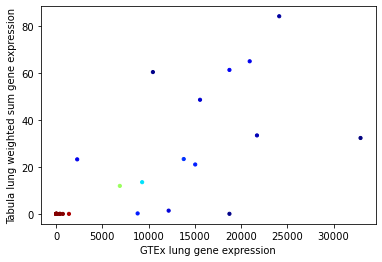

In [92]:
#scatterplot of mitochondrial-encoded genes across Tabula Sapiens virtual lung and GTEx lung
tabula_vs_GTEx_expression(expression_df.filter(items = mt_encoded_genes, axis = 0).GTEx_lung, 
                          expression_df.filter(items = mt_encoded_genes, axis = 0).sum_expression)

**Compare to the plot of all shared genes between Tabula Sapiens and GTEx lung**

<Figure size 432x288 with 0 Axes>

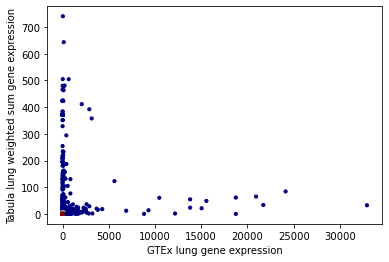

In [91]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

I can see that the mitochondrial genes account for most of the GTEx outliers seen when Tabula expression is low on the bottom of the plot. If I remove the mitochondrial genes how does this affect the scatterplot.

### 9.9.4 Plot expressions without MT-encoded genes

In [108]:
#filter out genes not in the expression df
MT_genes = [i for i in mt_encoded_genes if i not in ('ENSG00000210100', 'ENSG00000210151', 
                                                                    'ENSG00000210174', 'ENSG00000210184')]

<Figure size 432x288 with 0 Axes>

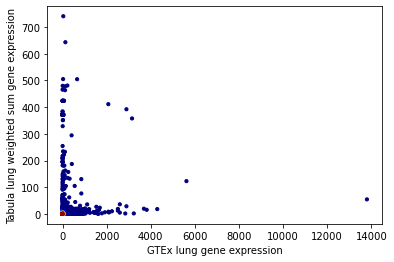

In [116]:
tabula_vs_GTEx_expression(expression_df.drop(index = MT_genes).GTEx_lung, 
                         expression_df.drop(index = MT_genes).sum_expression)

<Figure size 432x288 with 0 Axes>

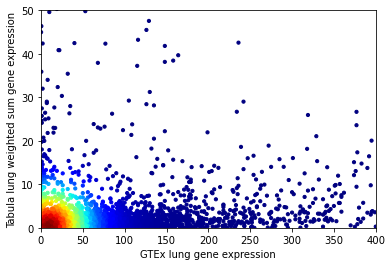

In [118]:
zoomed_tabula_vs_GTEx_expression(expression_df.drop(index = MT_genes).GTEx_lung, 
                         expression_df.drop(index = MT_genes).sum_expression)

I see that removing the mitochondrial-encoded genes removes a lot of the data points that had a lower Tabula virtual lung expression and a high GTEx expression.

# 10. Virtual lung using average_metric counts
## 10.1 Read in data

In [112]:
#read in average_metric tabula data
tabula = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

#filter out lung
lung = tabula.loc['UBERON:0002048']

In [114]:
#read in GTEx expressions
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')

#filter out lung cells and rename column
lung_GTEx = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0002048'])
lung_GTEx = lung_GTEx.rename(columns = {'UBERON:0002048': 'GTEx_lung'})

## 10.2 Identify shared genes between Tabula Sapiens lung and GTEx lung data

In [115]:
shared_genes = set(lung_GTEx.index) & set(lung.columns)
print(f' The number of shared genes between Tabula lung and GTEx lung is {len(shared_genes)}')

 The number of shared genes between Tabula lung and GTEx lung is 43482


## 10.3 Filter datasets for these genes

In [117]:
lung = lung.filter(items = shared_genes, axis = 1)
lung_GTEx = lung_GTEx.filter(items = shared_genes, axis = 0)

## 10.4 Calculate weighted median expressions for genes for each cell type
### 10.4.1 Identify proportions of each cell type

In [122]:
lung_counts = pd.read_pickle('lung_counts.pkl', compression = 'gzip')

lung_cell_type = pd.DataFrame(lung_counts.groupby('cell_type').ENSG00000223972.count())
lung_cell_type = lung_cell_type.rename(columns = {'ENSG00000223972': 'count'})

lung_cell_type['proportion'] = lung_cell_type['count'] / len(lung_counts)

### 10.4.2 Multiply each cell type row by the proportion

In [123]:
#list of cell type proportions
proportion_list = lung_cell_type['proportion'].to_list()

#multiply each column in the row by the corresponding cell type proportion
weighted_lung = lung.mul(proportion_list, axis = 0)

weighted_lung

,ENSG00000125388,ENSG00000225398,ENSG00000224231,ENSG00000223800,ENSG00000227568,ENSG00000152133,ENSG00000084090,ENSG00000004948,ENSG00000274685,ENSG00000001167,...,ENSG00000163564,ENSG00000280187,ENSG00000176244,ENSG00000227176,ENSG00000259404,ENSG00000272023,ENSG00000240940,ENSG00000160404,ENSG00000096996,ENSG00000184984
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,0.156636,230.242094,NaN,NaN,NaN,0.074117,0.095718,NaN,NaN,0.569870,...,0.041897,NaN,NaN,NaN,NaN,NaN,NaN,0.295256,NaN,NaN
alveolar fibroblast,83.419689,NaN,NaN,NaN,NaN,0.293143,0.091571,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.278293,NaN,NaN
b cell,NaN,NaN,NaN,NaN,NaN,0.155753,0.038494,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal cell,7.457336,NaN,NaN,NaN,NaN,0.528948,0.525191,NaN,NaN,1.297009,...,0.320453,173.391580,686.686027,NaN,NaN,NaN,NaN,0.887164,NaN,NaN
basophil,112.003551,NaN,NaN,NaN,NaN,0.479548,0.206199,NaN,NaN,0.165735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.786466,0.232530,NaN
bronchial smooth muscle cell,NaN,NaN,NaN,NaN,NaN,NaN,0.023292,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bronchial vessel endothelial cell,NaN,NaN,NaN,NaN,NaN,0.006692,0.004216,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary aerocyte,NaN,NaN,NaN,NaN,NaN,0.842614,0.278220,NaN,NaN,9.290659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.902755,NaN,NaN
capillary endothelial cell,284.709821,NaN,NaN,NaN,NaN,2.081739,0.406243,NaN,NaN,5.557273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.549579,NaN,NaN


In [124]:
weighted_lung.to_pickle('weighted_average_metric_lung.pkl', compression = 'gzip')

## 10.5 Sum of weighted expression for each gene across all cell types

In [125]:
lung = pd.read_pickle('weighted_average_metric_lung.pkl', compression = 'gzip')

In [126]:
sum_weighted_gene_expression = pd.DataFrame(lung.columns)

sum_expression = []
for i in lung.columns:
    sum_expression.append(lung[i].sum())
    
sum_weighted_gene_expression['sum_expression'] = sum_expression
sum_weighted_gene_expression = sum_weighted_gene_expression.rename(columns = {0: 'geneProductId'})
sum_weighted_gene_expression = sum_weighted_gene_expression.set_index('geneProductId')

## 10.6 Compare Tabula sum expression to GTEx

In [127]:
expression_df = pd.concat([sum_weighted_gene_expression, lung_GTEx], axis = 1)
expression_df

,sum_expression,GTEx_lung
ENSG00000125388,624.666231,2.669780
ENSG00000225398,5875.802922,2.353510
ENSG00000224231,0.000000,0.000000
ENSG00000223800,0.000000,0.000000
ENSG00000227568,0.000000,0.000000
...,...,...
ENSG00000272023,1706.746987,0.114631
ENSG00000240940,0.000000,0.000000
ENSG00000160404,37.127020,15.521000
ENSG00000096996,132.962835,4.631140


## 10.7 Plot Tabula data vs GTEx data

In [128]:
def tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    plt.show()
    
def zoomed_tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    plt.show()

<Figure size 432x288 with 0 Axes>

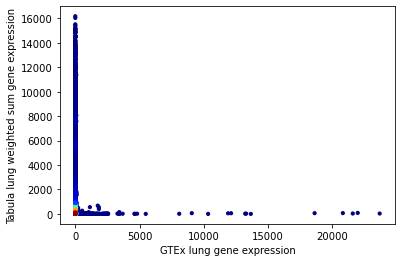

In [129]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

<Figure size 432x288 with 0 Axes>

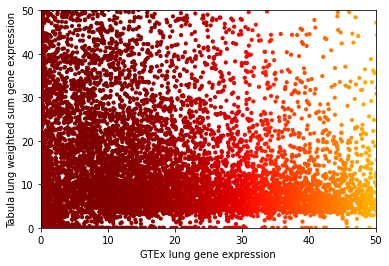

In [130]:
zoomed_tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

**Subset datapoints below 1000 for both datasets**

<Figure size 432x288 with 0 Axes>

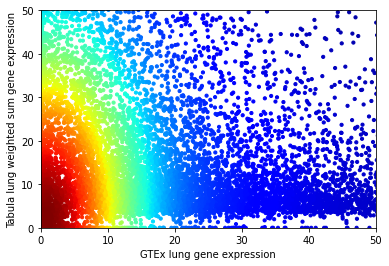

In [131]:
#subset dataframe to contain values less than 1000 for both datasets (correct for unmatched lengths)
df = expression_df[expression_df < 1000].dropna()

zoomed_tabula_vs_GTEx_expression(df.GTEx_lung, df.sum_expression)

**Plot histograms for both axes**

<AxesSubplot:xlabel='GTEx_lung', ylabel='Count'>

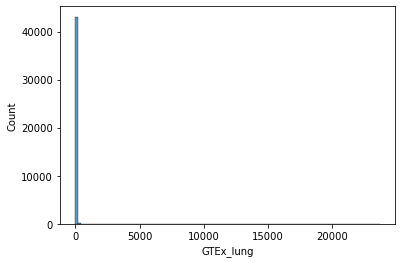

In [132]:
sns.histplot(data = expression_df, x = 'GTEx_lung', bins = 100)

<AxesSubplot:xlabel='GTEx_lung', ylabel='Count'>

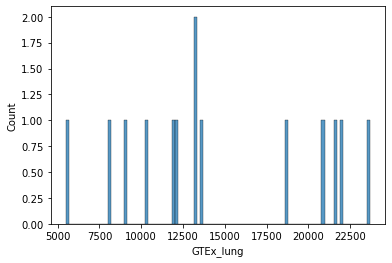

In [133]:
sns.histplot(data = expression_df[expression_df.GTEx_lung > 5000], x = 'GTEx_lung', bins = 100)

## 10.8 Normalisation of counts between GTEx and Tabula Sapiens

In [134]:
expression_df.sum()

sum_expression    4.172065e+07
GTEx_lung         8.913176e+05
dtype: float64

Here, we see that the sums of the two datasets are very different with the GTEx_lung counts equalling roughly 1 million (accounting for removal of genes) but the Tabula Sapien counts having between x10-x100 magnitude difference so we want to normalise these expressions.

In [135]:
#normalise for sum of counts
expression_df['sum_expression'] = (
    expression_df['sum_expression'] / expression_df['sum_expression'].sum()
) * 1000000
expression_df['GTEx_lung'] = (
    expression_df['GTEx_lung'] / expression_df['GTEx_lung'].sum()
) * 1000000

In [136]:
expression_df.sum()

sum_expression    1000000.0
GTEx_lung         1000000.0
dtype: float64

<AxesSubplot:xlabel='sum_expression', ylabel='Count'>

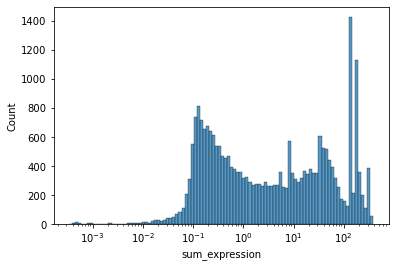

In [137]:
sns.histplot(data = expression_df, x = 'sum_expression', bins = 100, 
             log_scale = True)

This looks good and would be what you expect, especially since we have a threshold of 1 CPM so we don't see the huge numbers of zero-counts.

<AxesSubplot:xlabel='GTEx_lung', ylabel='Count'>

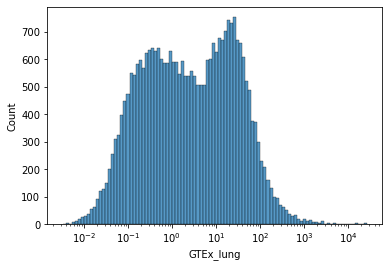

In [138]:
sns.histplot(data = expression_df, x = 'GTEx_lung', bins = 100, 
             log_scale = True)

**Putting these on the same axes scale**

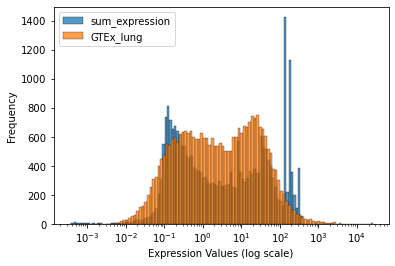

In [139]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first histogram
sns.histplot(data=expression_df, x='sum_expression', bins=100, log_scale=True, ax=ax, label='sum_expression')

# Plot the second histogram on the same axis
sns.histplot(data=expression_df, x='GTEx_lung', bins=100, log_scale=True, ax=ax, label='GTEx_lung')

# Add labels and legend
ax.set_xlabel('Expression Values (log scale)')
ax.set_ylabel('Frequency')
ax.legend()

# Show the plot
plt.show()

We can see that both distributions are bimodal and the range of values are roughly the same. This is good since the virtual lung was never expected to fully reflect the actual lung from the GTEx dataset therefore anything which vaguely resembles it is great.

In [140]:
expression_df.to_pickle('normalised_expression_df_virtual_lung.pkl', compression = 'gzip')

## 10.9 Plot Normalised Tabula data vs GTEx data
### 10.9.1

In [216]:
expression_df = pd.read_pickle('normalised_expression_df_virtual_lung.pkl', compression = 'gzip')

In [128]:
def tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    plt.show()
    
def zoomed_tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    plt.show()

<Figure size 432x288 with 0 Axes>

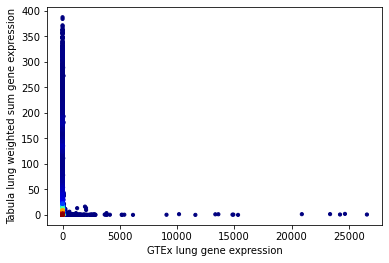

In [142]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

<Figure size 432x288 with 0 Axes>

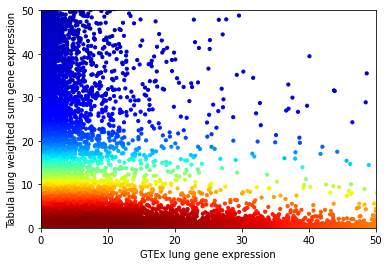

In [143]:
zoomed_tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

**Subset datapoints below 1000 for both datasets**

<Figure size 432x288 with 0 Axes>

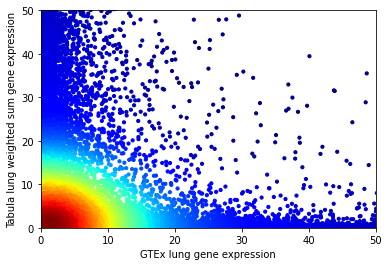

In [144]:
#subset dataframe to contain values less than 1000 for both datasets (correct for unmatched lengths)
df = expression_df[expression_df < 1000].dropna()

zoomed_tabula_vs_GTEx_expression(df.GTEx_lung, df.sum_expression)

**Subset datapoints below 400 for both datasets**

<Figure size 432x288 with 0 Axes>

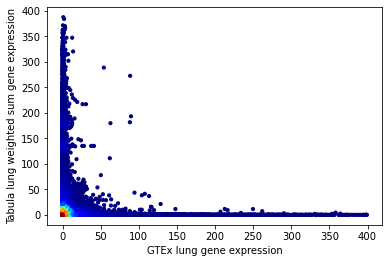

In [146]:
#subset dataframe to contain values less than 400 for both datasets (correct for unmatched lengths)
df = expression_df[expression_df < 400].dropna()

tabula_vs_GTEx_expression(df.GTEx_lung, df.sum_expression)

### 10.9.2 Eliminating mitochondrial genes and plotting again

In [148]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name', 'chromosome_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()

#subset out genes that are present on MT chromosome
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Chromosome/scaffold name'] == 'MT']

#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [154]:
dropped_mt_genes_df = expression_df.drop(index = mt_encoded_genes)

<Figure size 432x288 with 0 Axes>

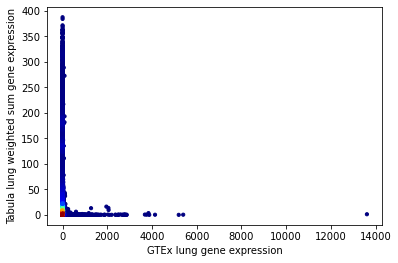

In [155]:
tabula_vs_GTEx_expression(dropped_mt_genes_df.GTEx_lung, dropped_mt_genes_df.sum_expression)

<Figure size 432x288 with 0 Axes>

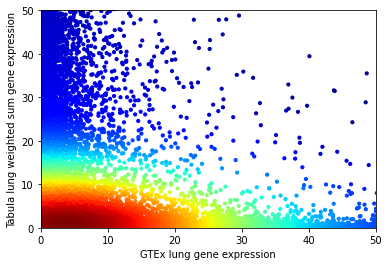

In [156]:
zoomed_tabula_vs_GTEx_expression(dropped_mt_genes_df.GTEx_lung, dropped_mt_genes_df.sum_expression)

# 11. Final GTEx v8 data vs Tabula Sapiens checks
## 11.1 Minimum GTEx expression counts in TPM

In [157]:
GTEx = pd.read_table('bulk-gex_v8_rna-seq_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz', 
                                skiprows = 2) #skips metadata rows

In [161]:
GTEx['Lung'].min()

0.0

<AxesSubplot:ylabel='Frequency'>

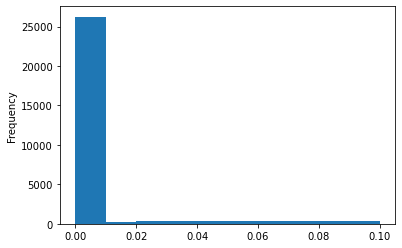

In [171]:
GTEx[GTEx.Lung < 0.1]['Lung'].plot.hist()

In [172]:
GTEx[(GTEx.Lung < 0.1) & (GTEx.Lung > 0)]['Lung']

6        0.039284
7        0.042960
8        0.035396
16       0.095579
25       0.037866
           ...   
55666    0.070215
55705    0.007712
55828    0.019191
55931    0.077512
56150    0.068283
Name: Lung, Length: 3276, dtype: float64

We see that there are minimum expression values falling below 1 TPM (3,276 genes in the lung) showing that in later GTEx versions they removed the minimum expression threshold.

## 11.2 Log-scaled KDE scatterplots
### 11.2.1 Transform data in log10 scaled

First, I need to transform the data into log10 scaled values in order for the KDE to work correctly.

In [212]:
expression_df[(expression_df == 0).all(axis = 1)]

,sum_expression,GTEx_lung
ENSG00000224231,0.0,0.0
ENSG00000223800,0.0,0.0
ENSG00000227568,0.0,0.0
ENSG00000274685,0.0,0.0
ENSG00000214614,0.0,0.0
...,...,...
ENSG00000248185,0.0,0.0
ENSG00000279534,0.0,0.0
ENSG00000233767,0.0,0.0
ENSG00000199030,0.0,0.0


In [213]:
expression_df[(expression_df == 0).any(axis = 1)]

,sum_expression,GTEx_lung
ENSG00000224231,0.0,0.000000
ENSG00000223800,0.0,0.000000
ENSG00000227568,0.0,0.000000
ENSG00000274685,0.0,0.000000
ENSG00000257964,0.0,0.211215
...,...,...
ENSG00000279534,0.0,0.000000
ENSG00000233767,0.0,0.000000
ENSG00000199030,0.0,0.000000
ENSG00000240940,0.0,0.000000


However, there are 12,052 genes where both datasets have zero expression and these can't be log10 scaled. There are 19,451 genes where one of the expressions is 0 so I will remove all of these from the analysis.

In [219]:
log10_scaled_expression_df = np.log10(expression_df[(expression_df != 0).all(axis = 1)])
log10_scaled_expression_df

,sum_expression,GTEx_lung
ENSG00000125388,1.175297,0.476443
ENSG00000225398,2.148716,0.421684
ENSG00000152133,-0.481145,0.945473
ENSG00000084090,-0.857239,2.074322
ENSG00000004948,1.543010,-1.093046
...,...,...
ENSG00000227176,1.683115,-0.029625
ENSG00000259404,0.949721,-1.257481
ENSG00000272023,1.611818,-0.890730
ENSG00000160404,-0.050661,1.240887


### 11.2.2 Plot data

In [220]:
def tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung normalized, log10 scaled gene expression')
    ax.set_ylabel('Tabula lung weighted normalized, log10 scaled sum gene expression')
    plt.show()
    
def zoomed_tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung normalized, log10 scaled gene expression')
    ax.set_ylabel('Tabula lung weighted normalized, log10 scaled sum gene expression')
    ax.set_xlim(-4, 5)
    ax.set_ylim(-4, 5)
    plt.show()

<Figure size 432x288 with 0 Axes>

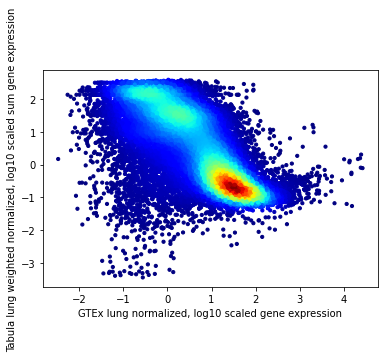

In [221]:
tabula_vs_GTEx_expression(log10_scaled_expression_df.GTEx_lung, log10_scaled_expression_df.sum_expression)

<Figure size 432x288 with 0 Axes>

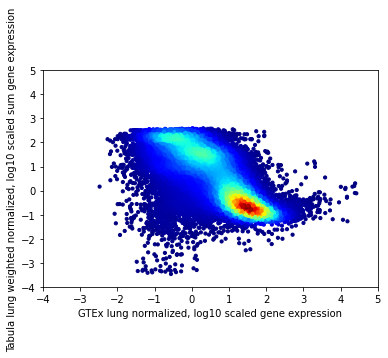

In [224]:
zoomed_tabula_vs_GTEx_expression(log10_scaled_expression_df.GTEx_lung, log10_scaled_expression_df.sum_expression)

# 12. Plotting code function
## 12.1 CREATE COUNTS DATAFRAME FOR ALL TISSUES

In [35]:
counts = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [36]:
counts = counts.iloc[:, 0:3]
counts['ENSG00000223972'] = counts['ENSG00000223972'].sparse.to_dense()
counts = pd.DataFrame(counts.groupby(['tissue', 'cell_type'], observed = True).count())
counts = counts.rename(columns = {'ENSG00000223972': 'count'})
counts

count
tissue         cell_type                         
UBERON:0000016 b cell                         117
               endothelial cell               173
               mast cell                       51
               myeloid cell                    57
               pancreatic acinar cell         442
...                                           ...
UBERON:0018707 plasma cell                   1141
               plasmacytoid dendritic cell     18
               smooth muscle cell             290
               t cell                        2916
               vein endothelial cell          278

[769 rows x 1 columns]

In [37]:
counts.to_pickle('tabula_counts.pkl', compression = 'gzip')

## 12.2 Function

In [104]:
#read in average_metric tabula counts, GTEx v8 median data and tabula counts
tabula = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')
GTEx = pd.read_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')
counts = pd.read_pickle('tabula_counts.pkl', compression = 'gzip')

def plot_tissue(tissue_uberonid):
    
    """
    Function to plot the KDE scatterplot for GTEx and Tabula Sapiens median data across a single tissue.
    
    Input:
        tissue_uberonid (string): UBERONID string for tissue of interest
        
    Output:
        histogram (plot): expression distribution for both datasets on a log-scale axis
        KDE scatterplot (plot): KDE scatterplot of GTEx vs Tabula expressions on log-scale axis
    """
    
    if (tissue_uberonid not in tabula.index) | (tissue_uberonid not in GTEx.index):
        raise Exception("The UBERON ID supplied is not present in one/both of the datasets.")
        
    else:
    
        #filter out tissue
        tabula_tissue = tabula.loc[tissue_uberonid]
        GTEx_tissue = pd.DataFrame(GTEx.loc[tissue_uberonid])

        #identify shared genes and filter datasets for these genes
        shared_genes = set(tabula_tissue.columns) & set(GTEx_tissue.index)
        tabula_tissue = tabula_tissue.filter(items = shared_genes, axis = 1)
        GTEx_tissue = GTEx_tissue.filter(items = shared_genes, axis = 0)

        #calculate weighted median expressions
        cell_type_counts = counts.loc[tissue_uberonid]
        cell_type_counts['proportion'] = cell_type_counts['count'] / cell_type_counts['count'].sum()
        proportion_list = cell_type_counts['proportion'].to_list()
        weighted_tissue = tabula_tissue.mul(proportion_list, axis = 0)

        #calculate sum of weighted median expressions across all cell_types so comparable to GTEx
        sum_weighted_tissue = pd.DataFrame(weighted_tissue.columns)
        sum_expression = []
        for i in weighted_tissue.columns:
            sum_expression.append(weighted_tissue[i].sum())

        #create df with weighted tabula expressions and GTEx expressions
        sum_weighted_tissue['sum_expression'] = sum_expression
        sum_weighted_tissue = sum_weighted_tissue.rename(columns = {0: 'ensemblid'}).set_index('ensemblid')
        expression_df = pd.concat([sum_weighted_tissue, GTEx_tissue], axis = 1)

        #normalise counts between the datasets
        expression_df['sum_expression'] = (expression_df['sum_expression'] / expression_df['sum_expression'].sum()) * 1000000
        expression_df[tissue_uberonid] = (expression_df[tissue_uberonid] / expression_df[tissue_uberonid].sum()) * 1000000

        ##creating the plots
        fig, ax = plt.subplots(1,2, figsize=(12, 6))

        #plot histogram of normalised expressions on log-scale axis
        sns.histplot(data = expression_df, x = 'sum_expression', bins = 100, log_scale = True, ax = ax[0], label = 'Tabula')
        sns.histplot(data = expression_df, x = tissue_uberonid, bins = 100, log_scale = True, ax = ax[0], label = 'GTEx')
        ax[0].set_xlabel('Expression Values (log scale)')
        ax[0].set_ylabel('Frequency')
        ax[0].legend()
        ax[0].set_title(f'{tissue_uberonid} Expression')


        #plot log10-scaled KDE scatterplot
        ## From: https://stackoverflow.com/a/20107592
        log10_scaled_expression_df = np.log10(expression_df[(expression_df != 0).all(axis = 1)])
        x = log10_scaled_expression_df[tissue_uberonid]
        y = log10_scaled_expression_df['sum_expression']

        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        plt.set_cmap('jet')
        ax[1].scatter(x, y, c=z, s=10)
        ax[1].set_xlabel('GTEx expression')
        ax[1].set_ylabel('Tabula expression')
        ax[1].set_title(f'{tissue_uberonid} KDE scatterplot')
        ax[1].set_xlim(-4, 5)
        ax[1].set_ylim(-4, 5)

        plt.tight_layout()

        return plt.show()

## 12.3 Example usage
### 12.3.1 Lung

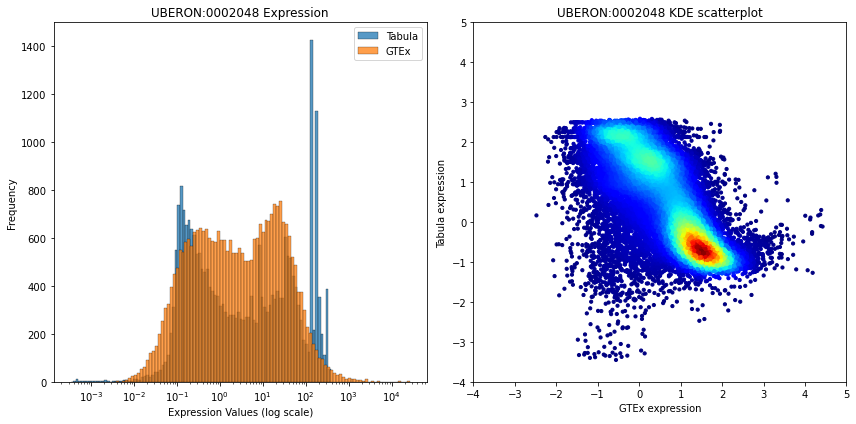

In [79]:
plot_tissue('UBERON:0002048')

### 12.3.2 Uterus

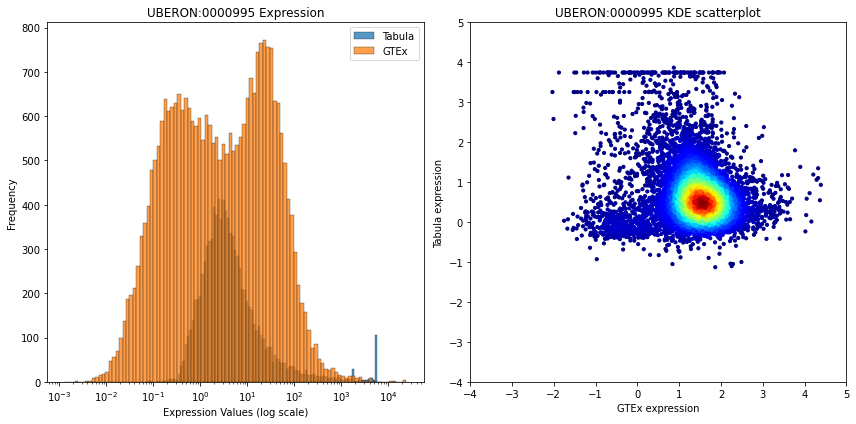

In [108]:
plot_tissue('UBERON:0000995')

### 12.3.3 Liver

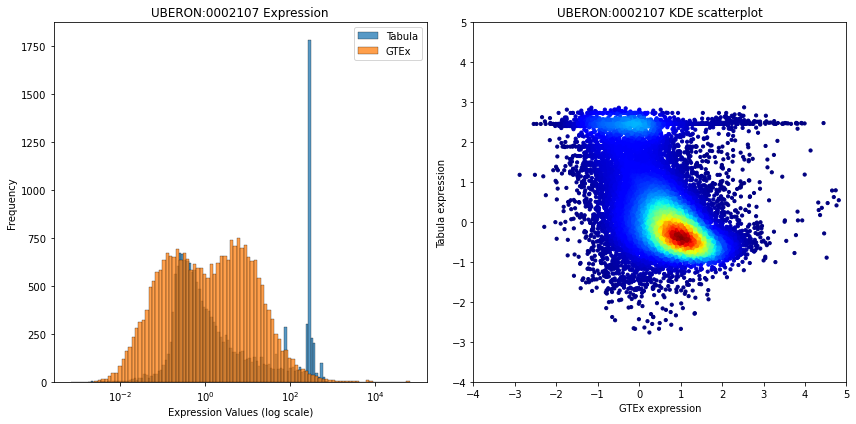

In [109]:
plot_tissue('UBERON:0002107')

### 12.3.4 Absent UBERONID

In [107]:
plot_tissue('UBERON:0011907')

Exception: The UBERON ID supplied is not present in one/both of the datasets.